In [3]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma as gf
from scipy.special import hyp1f1 as Mf

In [4]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# Moments: enforcing model structure

When investigating using moment confidence intervals, rather than probabilities, for feasibility tests of interacting models it was found that moment + CME constraints produced identical results to 'dummy' moment factorization constraints:

\begin{align*}
    \sum_{x_{1} = 0}^{max_1} x p_{1}(x) &\in \mathbb{E}[X_{1}] \text{ CI } \quad &\iff \quad y &\in \mathbb{E}[X_{1}] \text{ CI } \\
    \sum_{x_{2} = 0}^{max_2} x p_{2}(x) &\in \mathbb{E}[X_{2}] \text{ CI } &z &\in \mathbb{E}[X_{2}] \text{ CI } \\
    \left(\sum_{x_{1} = 0}^{max_1} x p_{1}(x) \right) \left(\sum_{x_{2} = 0}^{max_2} x p_{2}(x) \right) &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }  &y * z &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }\\

    \textbf{ + CME constraints}
    
\end{align*}

Suggesting that the moment bounds do not constrain probabilities enough for the CME to enforce the model structure e.g. taking non-poisson moments together with a birth-death CME remains feasible.

## Investigation

Use a birth-death model with 1 parameter $k$ and input moments bounds of width $\delta$ about the true value, investigating the resulting bounds on the parameter and probabilities.

Consider the effects of 2nd order moments, capture efficiency, downsampled optimization, etc

# Code

Functions to optimize a birth-death model using moment and CME constraints:

'optimize moment' uses the standard method, using observed moment intervals to bound expressions in terms of the original moments which are set equal to a sum over original probabilities, which are also constrained by the CME.

'optimize moment downsampled' is on the observed scale, using observed moment intervals to directly bound a sum over observed probabilities, which are also constrained by the downsampled CME.

## Settings

- M: size of truncation used for the moment sums $\sum \limits_{x=0}^{M} xp(x)$
- k: birth-death model parameter $k = \frac{k_{tx}}{k_{deg}}$
- a, b: capture efficiency parameters $\beta \sim Beta(a, b)$
- delta: width of input 1st moment bounds about the true value
- deltasq: width of input 2nd moment bounds about the true value
- deltam: width of input $f_{m}$ bounds about the true value (downsampled only)
- gamma: bias added to 2nd moment for non-poisson moments
- var: bool to include the 2nd moment

In [11]:
def optimize_moment(M, k, a, b, delta, deltasq, gamma=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    delta: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [12]:
def fm_numeric(m ,a, b, k):
    '''Numeric computation of f_m = E[Beta|m] for Beta~Beta(a,b) capture.'''

    # terms
    t1 = gf(b + m + a) / gf(m + a)
    t2 = gf(m + a + 1) / gf(b + m + a + 1)
    t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

    # numerical computation of fm
    fm_num = t1 * t2 * t3

    return fm_num

In [13]:
def optimize_moment_downsampled(M, k, a, b, delta, deltasq, gamma=0.0, deltam=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    deltasq: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    deltam: width of fm intervals about truth
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            fm = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="fm", lb=0, ub=1)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OB)
            expr_EX_OB = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OB = gp.quicksum(p * np.arange(M + 1)**2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # fm intervals
            for m in range(M + 1):
                fm_num = fm_numeric(m, a, b, k)
                model.addConstr(fm[m] <= fm_num + (deltam / 2))
                model.addConstr(fm[m] >= fm_num - (deltam / 2))

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - fm[0] * k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == fm[x - 1] * k_tx * p[x - 1] + (x + 1) * p[x + 1] - (fm[x] * k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

# Parameter Bounds

Investigate bounds on the parameter $k$

## Perfect information

Using $\delta = 0$ we input the exact moment values:

In [206]:
# standard
print("1st Moment:")
solution_s1 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_s2 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

1st Moment:
k_tx in (2.0, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL


And again for downsampled optimization use $\delta = \delta_{m} = 0$:

In [207]:
# downsampled
print("1st Moment:")
solution_d1 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_d2 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

1st Moment:
k_tx in (1.9998567730024175, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (1.9999849986008067, 2.000258939999257), status OPTIMAL, OPTIMAL


For both methods:

- 1st moment: exact lower bound, no upper bound
- 1st & 2nd moment: exact lower & upper bounds

This does not depend on capture efficiency, with the results shown above at $\beta \sim Beta(1, 20)$

## Input Interval Width $\delta$

Input moment bounds of width $\delta$, $30 \delta^2$ (*) about true values

(*) see 'Realistic $\delta$ values' section for reasoning

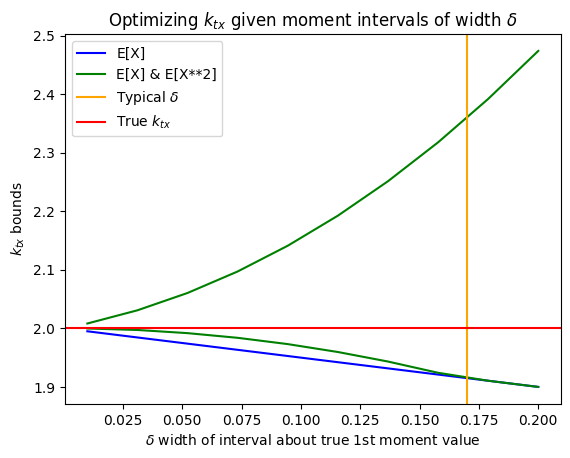

In [212]:
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
b = 0
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
for delta in deltas:
    solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=False)
    solution_moment_var = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
plt.title(r"Optimizing $k_{tx}$ given moment intervals of width $\delta$")
plt.xlabel(r"$\delta$ width of interval about true 1st moment value")
plt.ylabel(r"$k_{tx}$ bounds")
plt.plot(deltas, lbs_moment, color="blue", label="E[X]")
plt.plot(deltas, lbs_moment_var, color="green", label="E[X] & E[X**2]")
# plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, ubs_moment_var, color="green")
plt.axvline(0.17, color="orange", label=r"Typical $\delta$")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

As expected, the width of output bounds on $k_{tx}$ increases with width of input bounds on moments $\delta$: the lower bound scales slightly better with $\delta$, roughly linear for both, while the upper bound starts to accelerate.

For the setting of $k = 2$ and no capture efficiency the average bootstrap interval width is shown in orange, producing a reasonable bound of ~$[1.9, 2.3]$ on the parameter, which suggests there is some enforcement of the model structure for this to be so narrow.

(NOTE: do not show upper bound for E[X] optimization as is just a constant $K = 100$)

(NOTE: do not show downsampled here, as with no capture efficiency is just the same (unless intervals on $f_{m}$ used))

## Capture efficiency $\beta$ Impact

Now consider adding capture efficiency to the input


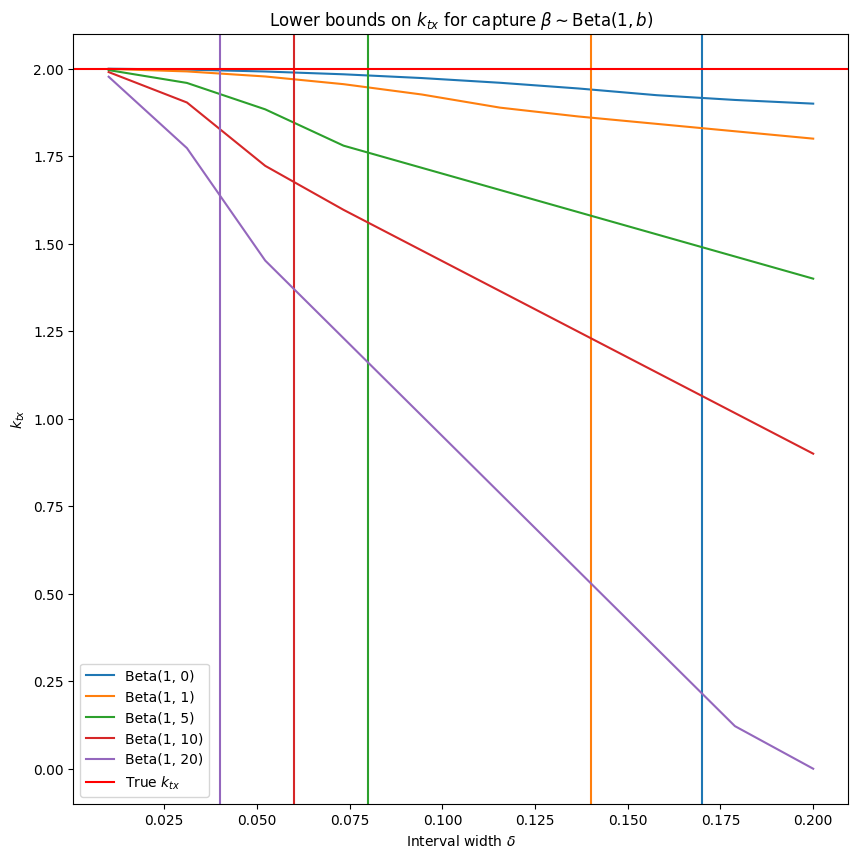

In [221]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"Lower bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

As the capture efficiency decreases, the the lower bound scales worse with $\delta$, but the average width given by the bootstrap in practice also decreases (shown by the vertical lines).

Overall, the lower bound on $k$ at average width decreases with lower capture, reaching ~$1.7$ at $Beta(1, 20)$

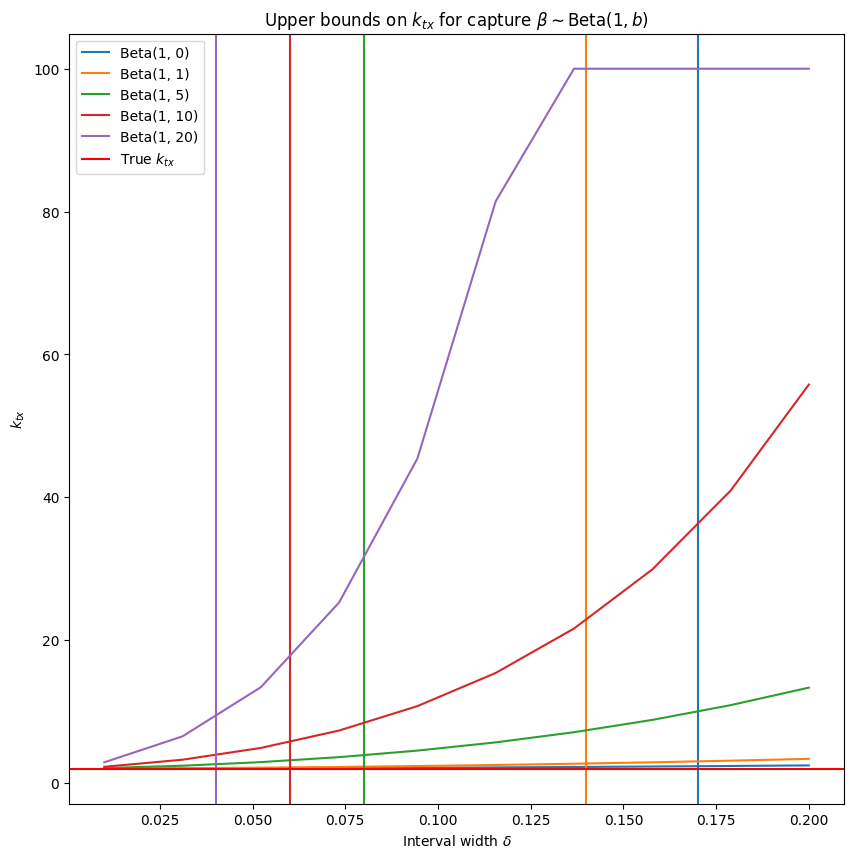

In [222]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"Upper bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, ubs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

Again as the capture efficiency decreases, the the upper bound scales worse with $\delta$, but the average width given by the bootstrap in practice also decreases (shown by the vertical lines). The scaling is worse than with the lower bound, especially for the lower capture efficiencies whose bounds grow very rapidly.

Overall, the upper bound on $k$ at average width increases with lower capture, reaching ~$10$ at $Beta(1, 20)$

### Downsampled moment constraints

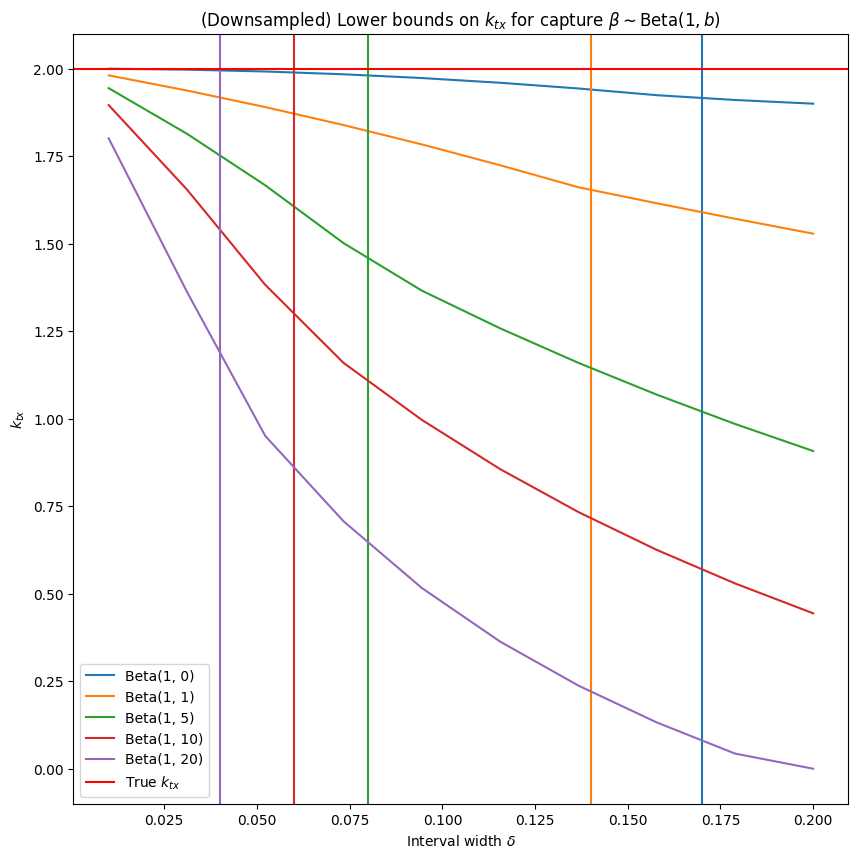

In [293]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Lower bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

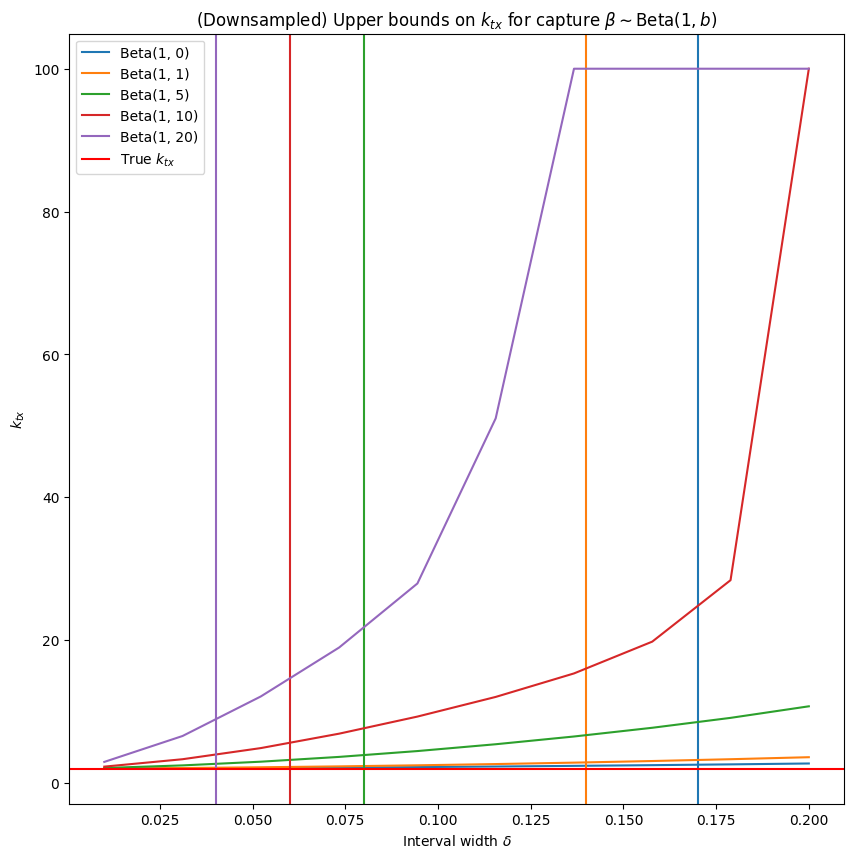

In [295]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Upper bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, ubs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

Downsampled optimization allows the use of a much smaller number of states (moment sum truncation M down from ~$100$ to ~$10$), but comes at the cost of additional uncertainity in the downsampled rates $f_{m}$. Overall this leads to slightly worse results e.g. lower bound for $Beta(1, 20)$ is ~$1.2$ vs ~$1.7$, but this can be considered a tradeoff for the smaller optimization.

An interval of width $\delta$ (same as 1st moment) about the true $f_{m}$ values was used: the 'Realistic $\delta$ values' shows that this is similar to the average width seen in practice. However, like probabilities the widths vary widely depending on the state, number of occurences in the sample, etc so performance here may be worse than in reality.

#### No $f_{m}$ interval

Roughly the same results as standard moment optimization, when using 'point estimates' of $f_{m}$'s (exact value, $\delta_{m} = 0$)

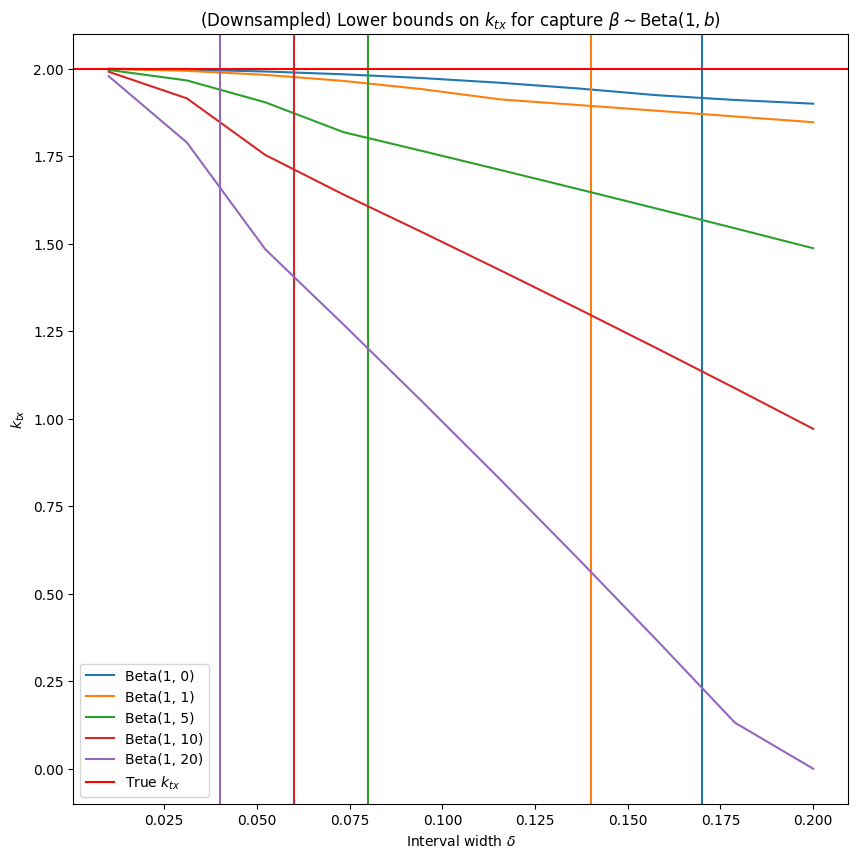

In [42]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Lower bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=0.0, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

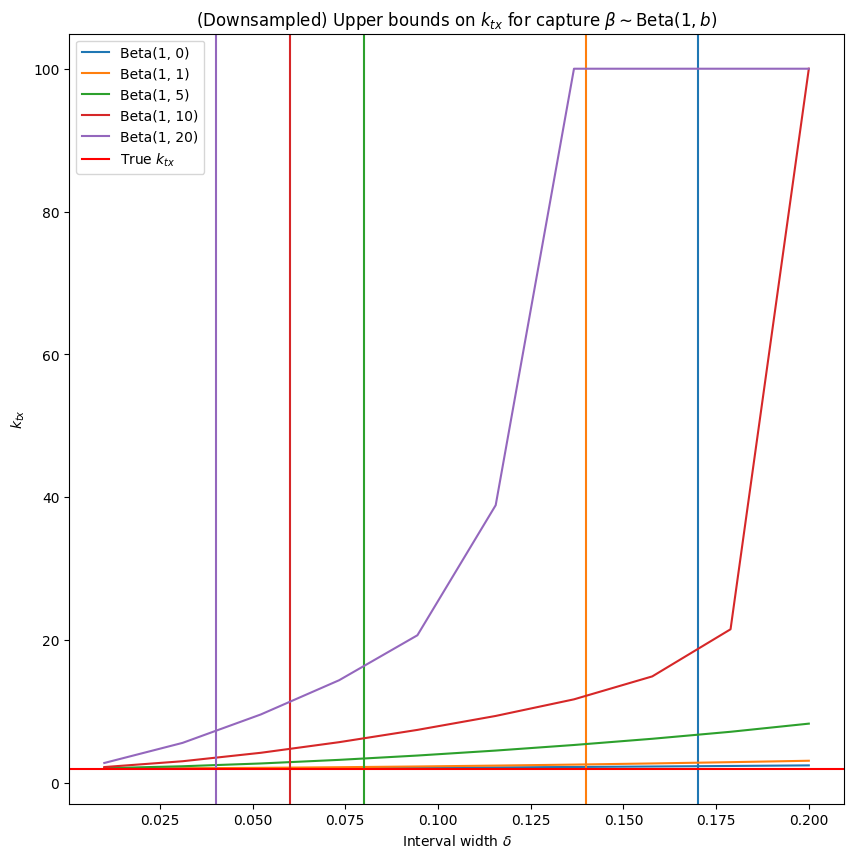

In [43]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Upper bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=0, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, ubs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

## Non-poisson moments

Looking back to using moments to enforce model structure, a main issue was the lack of infeasibility when non-poisson data is used as an input.

To investigate we take the true moment values for a poisson distribution and add a bias of $\gamma$ to the 2nd moment: the resulting mean $\ne$ variance, and the distribution should not satisfy a birth-death CME

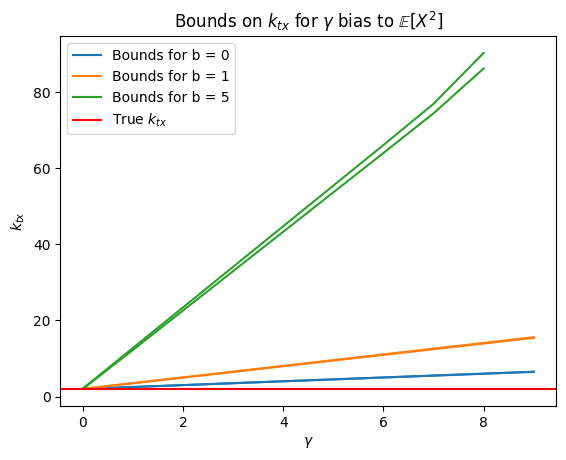

In [307]:
# settings
delta = 0.01
k = 2
M = 100
a = 1
bs = [0, 1, 5]
gammas = [g for g in range(10)]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, gamma, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}", color=f'C{i}')
    plt.plot(gammas, ubs_moment, color=f'C{i}')
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [110]:
solution_moment = optimize_moment(M=100, k=2, a=1, b=0, delta=0.1, deltasq=30 * (0.1**2), gamma=-1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Interestingly, the optimization remains feasible for $\gamma > 0$ and the resulting bounds remain tight (for small $\delta$) but about the wrong values of $k$, as shown by the plot above.

When $\gamma < 0$ the optimization is infeasible (even for roughly average $\delta$) as it should be.

### Downsampled moments

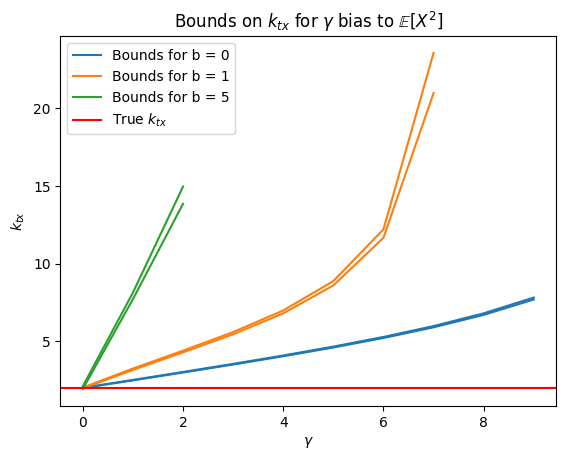

In [313]:
# settings
delta = 0.01
k = 2
M = 10
a = 1
bs = [0, 1, 5]
gammas = [g for g in range(10)]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, gamma, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}", color=f'C{i}')
    plt.plot(gammas, ubs_moment, color=f'C{i}')
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [317]:
solution_moment = optimize_moment_downsampled(M=10, k=2, a=1, b=0, delta=0.1, deltasq=30 * (0.1**2), gamma=-1, deltam=0.1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Largely the same results occur.

## Probability comparison

Briefly simulate, bootstrap and use probability optimization to produce bounds on $k$ for the range of capture efficiencies used above. Compare the results to moment & moment downsampled results for typical $\delta$ at each capture

(NOTE: for true comparison should also bootstrap moments, but probably close enough)

In [3]:
from interaction_inference import constraints, simulation, optimization

In [31]:
def optimize(self, i):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize rate, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            solution = {}
            model.setObjective(variables['k_tx_1'], GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(variables['k_tx_1'], GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

    return solution

In [32]:
rng = np.random.default_rng()

In [33]:
'''
# settings
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]

# solutions
prob_lbs = []
prob_ubs = []

# simulate data
data = simulation.simulate_dataset_range_BD("test", [0], rate=k)

# capture
for i, b in enumerate(bs):

    # simulate capture
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)

    # downsampled data
    dataset = data.downsample("test", beta)
    dataset.compute_probabilities()

    # optimize (feasibility, just to get attributes sorted)
    opt = optimization.Optimization(
        dataset,
        [
            "marginal_probability_1",
            "marginal_CME_1",
            "k_deg_1"
        ],
        license_file="../../../WLS_credentials.json",
        print_solution=False,
        tqdm_disable=True,
        time_limit=1
    )

    # reset time limit
    opt.time_limit = 300

    # re-optimize (bound k_tx)
    sol = optimize(opt, 0)

    prob_lbs.append(sol['min'])
    prob_ubs.append(sol['max'])
'''

'\n# settings\nk = 2\nM = 10\na = 1\nbs = [0, 1, 5, 10, 20]\n\n# solutions\nprob_lbs = []\nprob_ubs = []\n\n# simulate data\ndata = simulation.simulate_dataset_range_BD("test", [0], rate=k)\n\n# capture\nfor i, b in enumerate(bs):\n\n    # simulate capture\n    if b == 0:\n        beta = np.ones(1000)\n    else:\n        beta = rng.beta(1, b, size=1000)\n\n    # downsampled data\n    dataset = data.downsample("test", beta)\n    dataset.compute_probabilities()\n\n    # optimize (feasibility, just to get attributes sorted)\n    opt = optimization.Optimization(\n        dataset,\n        [\n            "marginal_probability_1",\n            "marginal_CME_1",\n            "k_deg_1"\n        ],\n        license_file="../../../WLS_credentials.json",\n        print_solution=False,\n        tqdm_disable=True,\n        time_limit=1\n    )\n\n    # reset time limit\n    opt.time_limit = 300\n\n    # re-optimize (bound k_tx)\n    sol = optimize(opt, 0)\n\n    prob_lbs.append(sol[\'min\'])\n    pr

In [35]:
# solutions
prob_lbs = []
prob_ubs = []
moment_lbs = []
moment_ubs = []
Dmoment_lbs = []
Dmoment_ubs = []

# settings
k = 2
bs = [0, 1, 5, 10, 20]

# simulate data
data = simulation.simulate_dataset_range_BD("test", [0], rate=k)

# capture
for i, b in enumerate(bs):

    # simulate capture
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)

    # downsampled data
    dataset = data.downsample("test", beta)
    dataset.bootstrap_marginal_probabilities()
    dataset.bootstrap_marginal_fm()

    # optimize (feasibility)
    opt = optimization.Optimization(
        dataset,
        [
            "downsampled_marginal_probability_1",
            "downsampled_marginal_CME_1",
            "k_deg_1"
        ],
        license_file="../../../WLS_credentials.json",
        print_solution=False,
        tqdm_disable=True
    )

    # re-optimize (bound k_tx)
    sol = optimize(opt, 0)

    prob_lbs.append(sol['min'])
    prob_ubs.append(sol['max'])

# settings
k = 2
M = 100
a = 1

# run at typical delta for each capture
deltas = [0.17, 0.14, 0.08, 0.06, 0.04]

# moments
for i, b in enumerate(bs):
    delta = deltas[i]
    solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
    moment_lbs.append(solution_moment['min'])
    moment_ubs.append(solution_moment['max'])

# settings
M = 10

# downsampled moments
for i, b in enumerate(bs):
    delta = deltas[i]
    solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
    Dmoment_lbs.append(solution_moment['min'])
    Dmoment_ubs.append(solution_moment['max'])

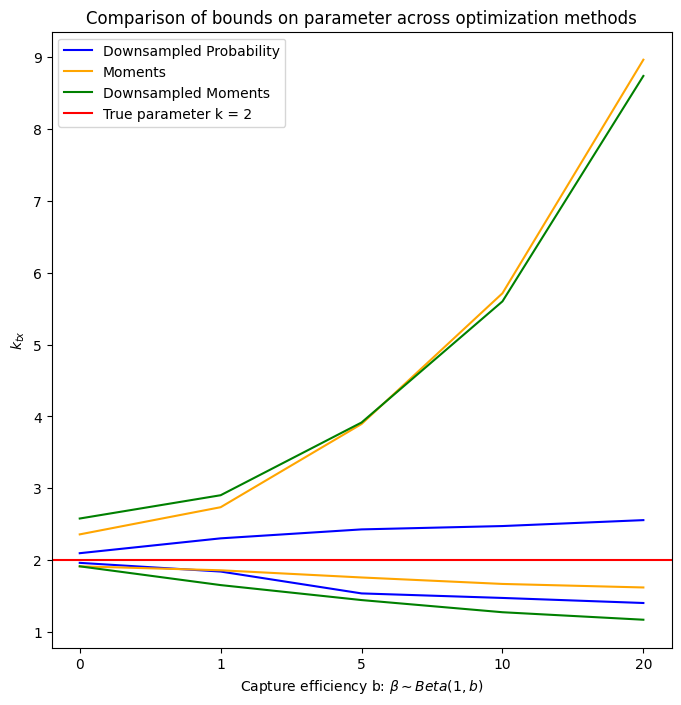

In [36]:
fig, axs = plt.subplots(figsize=(8, 8))
axs.plot(prob_lbs, color="blue", label="Downsampled Probability")
axs.plot(prob_ubs, color="blue")
axs.plot(moment_lbs, color="orange", label="Moments")
axs.plot(moment_ubs, color="orange")
axs.plot(Dmoment_lbs, color="green", label="Downsampled Moments")
axs.plot(Dmoment_ubs, color="green")
axs.axhline(2, color="red", label=f"True parameter k = {k}")
axs.set_xticks(range(5))
axs.set_xticklabels([0, 1, 5, 10, 20])
axs.set_xlabel(r"Capture efficiency b: $\beta \sim Beta(1, b)$")
axs.set_ylabel(r"$k_{tx}$")
axs.set_title("Comparison of bounds on parameter across optimization methods")
plt.legend()

(Downsampled) Probability optimization produces tight bounds on the parameter $k$ across the range of capture efficiencies. The moment optimizations (standard and downsampled) give similar results, with the lower bounds close & better than probabilities respectively. However, the upper bounds are not as good, rapidly diverging from the true value / probability bounds for lower capture.

## Higher moments

In [53]:
def optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=0.0, gammacb=0.0, silent=True, printing=True, time_limit=300, var=False, cb=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    delta: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))
    Ebeta3 = (a * (a + 1) * (a + 2)) / ((a + b + 2) * (a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    EX3_OB_LB = (k**3 + 3*(k**2) + k)*Ebeta3 + (k + k**2)*(3*Ebeta2 - 3*Ebeta3) + k*(2*Ebeta3 - 3*Ebeta2 + Ebeta) + gammacb - (deltacb / 2)
    EX3_OB_UB = (k**3 + 3*(k**2) + k)*Ebeta3 + (k + k**2)*(3*Ebeta2 - 3*Ebeta3) + k*(2*Ebeta3 - 3*Ebeta2 + Ebeta) + gammacb + (deltacb / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)
            if cb:
                expr_EX3_OG = gp.quicksum(p * np.arange(M + 1)**3)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)
            if cb:
                expr_EX3_OB = expr_EX3_OG*Ebeta3 + expr_EX2_OG*(3*Ebeta2 - 3*Ebeta3) + expr_EX_OG*(2*Ebeta3 - 3*Ebeta2 + Ebeta)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")
            if cb:
                model.addConstr(expr_EX3_OB <= EX3_OB_UB, name="EX3_UB")
                model.addConstr(expr_EX3_OB >= EX3_OB_LB, name="EX3_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

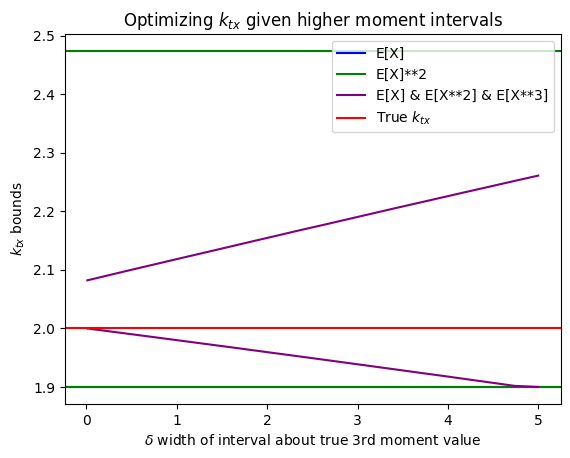

In [9]:
# settings
delta = 0.2
deltasq = 30*(0.2)**2
deltas = np.linspace(0.01, 5, 20)
k = 2
M = 100
a = 1
b = 0

# optimize 1st, <2nd moments (typical width)
solution_moment = optimize_higher_moment(M, k, a, b, delta, deltasq, 0, printing=False, var=False)
solution_moment_var = optimize_higher_moment(M, k, a, b, delta, deltasq, 0, printing=False, var=True)

# display
plt.axhline(solution_moment['min'], color="blue", label="E[X]")
plt.axhline(solution_moment_var['min'], color="green", label="E[X]**2")
plt.axhline(solution_moment_var['max'], color="green")

# optimize over range of <3rd moment widths
lbs_moment_cb = []
ubs_moment_cb = []
for deltacb in deltas:
    solution_moment_cb = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, printing=False, var=True, cb=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
    lbs_moment_cb.append(solution_moment_cb['min'])
    ubs_moment_cb.append(solution_moment_cb['max'])
plt.title(r"Optimizing $k_{tx}$ given higher moment intervals")
plt.xlabel(r"$\delta$ width of interval about true 3rd moment value")
plt.ylabel(r"$k_{tx}$ bounds")
#plt.plot(deltas, lbs_moment, color="blue", label="E[X]")
#plt.plot(deltas, lbs_moment_var, color="green", label="E[X] & E[X**2]")
plt.plot(deltas, lbs_moment_cb, color="purple", label="E[X] & E[X**2] & E[X**3]")
# plt.plot(deltas, ubs_moment, color="blue")
#plt.plot(deltas, ubs_moment_var, color="green")
plt.plot(deltas, ubs_moment_cb, color="purple")
#plt.axvline(0.17, color="orange", label=r"Typical $\delta$")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

Taking typical $\mathbb{E}[X]$ and $\mathbb{E}[X^2]$ interval widths of $0.2$ and $1.2$ (average bootstrap interva widths at $\beta = 1$), consider adding 3rd moment bounds to the optimization constraints, taking a range on input interval widths.

We see that even for very large widths, the additional moment significantly improves the bounds on the parameter (especially the upper bound). A typical $\delta$ in practice seems to be ~$2 - 3$ (needs more testing), so would definitely improve results, but is a tradeoff for the additional complexity.

In [72]:
# settings
delta = 0.2
deltasq = 30*(0.2)**2
deltacb = 3
k = 2
M = 100
a = 1
b = 0

# gamma bias
gamma = 1
print(r"$\gamma = 1$")

# optimize
print("\nE[X]")
solution_moment = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=False)
print("E[X**2]")
solution_moment_var = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=True)
print("E[X**3]")
solution_moment_cb = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=True, cb=True)
print("")

# gamma bias
gamma = -1
print(r"$\gamma = -1$")

# optimize
print("\nE[X]")
solution_moment = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=False)
print("E[X**2]")
solution_moment_var = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=True)
print("E[X**3]")
solution_moment_cb = optimize_higher_moment(M, k, a, b, delta, deltasq, deltacb, gamma=gamma, printing=True, var=True, cb=True)

$\gamma = 1$

E[X]
k_tx in (1.9, 100.0), status OPTIMAL, OPTIMAL
E[X**2]
k_tx in (2.078880089562051, 3.0), status OPTIMAL, OPTIMAL
E[X**3]
k_tx in (None, None), status INFEASIBLE, INFEASIBLE

$\gamma = -1$

E[X]
k_tx in (1.9, 100.0), status OPTIMAL, OPTIMAL
E[X**2]
k_tx in (1.9, 1.9473684210526325), status OPTIMAL, OPTIMAL
E[X**3]
k_tx in (None, None), status INFEASIBLE, INFEASIBLE


However, also see that the addition of 3rd moment can improve infeasibility in cases of non-poisson moments: here the 1st and 2nd moments are not enough to cause infeasibility for $\gamma = \pm 1$, but adding the 3rd moment is.

This may not work in practice: here we only add a bias to the 2nd moment and use 'poisson' values for 2st and 3rd moments, in reality all moments may be perturbed from a poisson fit, and 3rd moment width may be larger than expected.

___

Overall, shows that higher moments do provide additional information, and while the improvement to output bound width may not be worth the tradeoff for increased complexity, could be useful to enforce model constraints by getting more out of the data.

# Distribution bounds

Investigate the bounds on the distribution $p$ when using moment bounds as constraints.

## Code

In [157]:
def optimize_moment_p(M, k, a, b, delta, deltasq, gamma=0.0, silent=True, printing=True, time_limit=300, var=False, CME=True, ktx=None):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of moment intervals about truth
    deltasq: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    ktx: optional fixed parameter
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = {}# json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # optional fixed parameter
            if ktx:
                model.addConstr(k_tx == ktx, name="Fixed_parameter")

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                    ),
                    name="CME_x1_x2"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                solution = {
                    'min': None,
                    'min_status': 'INFEASIBLE',
                    'max': None,
                    'max_status': 'INFEASIBLE',
                    'p': -np.ones((M + 1, 2))
                }
                return solution

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((M + 1, 2))
            for x in range(M + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [158]:
def optimize_moment_downsampled_p(M, k, a, b, delta, deltasq, gamma=0.0, deltam=0.0, silent=True, printing=True, time_limit=300, var=False, CME=True, ktx=None):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    deltasq: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    deltam: width of fm intervals about truth
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    ktx: optional fixed parameter
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            fm = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="fm", lb=0, ub=1)

            # optional fixed parameter
            if ktx:
                model.addConstr(k_tx == ktx, name="Fixed_parameter")

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OB)
            expr_EX_OB = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OB = gp.quicksum(p * np.arange(M + 1)**2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # fm intervals
            for m in range(M + 1):
                fm_num = fm_numeric(m, a, b, k)
                model.addConstr(fm[m] <= fm_num + (deltam / 2))
                model.addConstr(fm[m] >= fm_num - (deltam / 2))

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - fm[0] * k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == fm[x - 1] * k_tx * p[x - 1] + (x + 1) * p[x + 1] - (fm[x] * k_tx + x) * p[x] for x in range(1, M)
                    ),
                    name="CME_x1_x2"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == 'INFEASIBLE':
                solution = {
                    'min': None,
                    'min_status': 'INFEASIBLE',
                    'max': None,
                    'max_status': 'INFEASIBLE',
                    'p': -np.ones((M + 1, 2))
                }
                return solution

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((M + 1, 2))
            for x in range(M + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [144]:
def optimize_standard_p(self, i):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize distribution, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            N = self.overall_extent_OG[f'sample-{i}']['max_x1_OG'] + 1
            p_bounds = np.empty((2, N))

            for i in range(N):
                model.setObjective(variables['p1'][i], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[0, i] = model.ObjVal
                except:
                    p_bounds[0, i] = None

                model.setObjective(variables['p1'][i], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[1, i] = model.ObjVal
                except:
                    p_bounds[1, i] = None

    return p_bounds

In [145]:
def optimize_downsampled_p(self, i):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize distribution, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            N = self.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1
            p_bounds = np.empty((2, N))

            for i in range(N):
                model.setObjective(variables['pd1'][i], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[0, i] = model.ObjVal
                except:
                    p_bounds[0, i] = None

                model.setObjective(variables['pd1'][i], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[1, i] = model.ObjVal
                except:
                    p_bounds[1, i] = None

    return p_bounds

## (No CME) Moment -> Probability

In optimization the input bounds (whether moments or probabilities) will constrain the probabilities and be combined with CME constraints. Since the CME constraints are identical across both optimizations we consider removing them and comparing the bounds enforced by the moment constraints:

$$ \sum \limits_{x=0}^{M} xp(x) \in \text{CI} $$
$$ \sum \limits_{x=0}^{M} x^{2}p(x) \in \text{CI} $$

to those given directly by the bootstrap.

Both of these bounds show what information on the distribution is gained from the data (when ignoring model constraints)

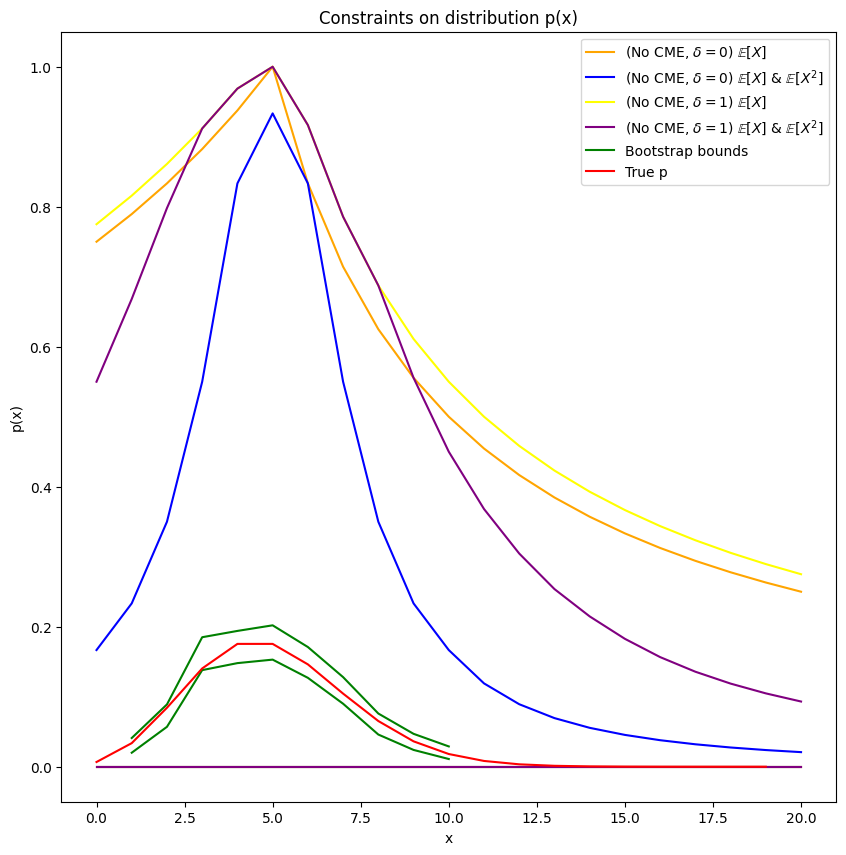

In [69]:
# settings
delta = 0.0
k = 5
M = 20
a = 1
b = 0

# plotting
fig, axs = plt.subplots(figsize=(10, 10))

# E[X] optimization
solution_moment = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=False, CME=False)
axs.plot(solution_moment['p'][:, 0], color="orange", label=r"(No CME, $\delta = 0$) $\mathbb{E}[X]$")
axs.plot(solution_moment['p'][:, 1], color="orange")

# E[X] & E[X**2] optimization
solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=False)
axs.plot(solution_moment_var['p'][:, 0], color="blue", label=r"(No CME, $\delta = 0$) $\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
axs.plot(solution_moment_var['p'][:, 1], color="blue")

# large delta
delta = 1.0

# E[X] optimization
solution_moment = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=False, CME=False)
axs.plot(solution_moment['p'][:, 0], color="yellow", label=r"(No CME, $\delta = 1$) $\mathbb{E}[X]$")
axs.plot(solution_moment['p'][:, 1], color="yellow")

# E[X] & E[X**2] optimization
solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=False)
axs.plot(solution_moment_var['p'][:, 0], color="purple", label=r"(No CME, $\delta = 1$) $\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
axs.plot(solution_moment_var['p'][:, 1], color="purple")

# probability bootstrap
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
data.bootstrap_marginal_probabilities()
lb = [x if x > 0 else None for x in data.probs_OB['sample-0']['x1_bounds'][0, :]]
ub = [x if x < 1 else None for x in data.probs_OB['sample-0']['x1_bounds'][1, :]]
axs.plot(lb, color="green", label="Bootstrap bounds")
axs.plot(ub, color="green")

# true distribution
axs.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

Even for perfect input moments at $\delta = 0$ the constraints enforced on $p$ are very weak (1st moment alone being worse than 1st & 2nd moments), giving all zero lower bounds and large upper bounds. The bootstrap produces much tighter bounds about the true distribution, although for a smaller range of states as truncation is used to prevent errors.

Interestingly, widening input intervals to $\delta = 1$ (much larger than seen in practice) makes little difference to the results, but this is not very impactful.

(NOTE: for no capture efficiency downsampled moments produce the same results, and still very similar when bounds on $f_{m}$ used)

### Capture efficiency $\beta$

For a range of capture efficiencies, use typical $\delta$ values (*) to compare bounds on distribution for moments vs bootstrap vs true value

(*) See 'Realistic delta values' section
___

$$ p^{OB}(x) = \frac{k^{x}}{x!}e^{-x} $$
$$ p^{OG}(x) = \frac{1}{n} \sum \limits_{j=1}^{n} \frac{(\beta_{j}k)^{x}}{x!}e^{-\beta_{j}k} $$

Standard moments: optimize $p^{OG}$ \
Downsampled moments: optimize $p^{OB}$ \
Bootstrap: bounds $p^{OB}$

So when capture efficiency $\beta < 1$ we can compare bounds on the observed distribution $p^{OB}$ for downsampled moments and the bootstrap, but not standard moments which bound the original distribution $p^{OG}$.

#### $p^{OG}$ Moments vs True Distribution

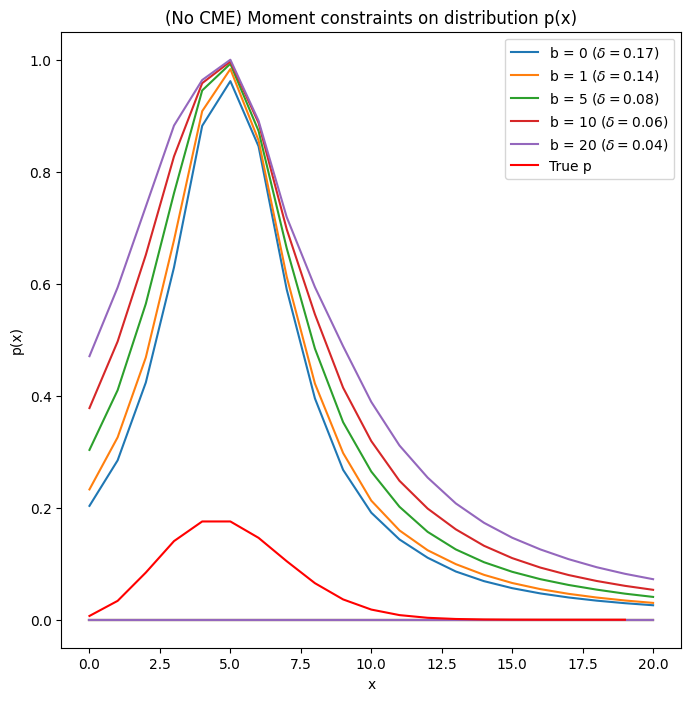

In [75]:
# settings
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plotting
fig, axs = plt.subplots(figsize=(8, 8))

# E[X] & E[X**2] optimization
for i, b in enumerate(bs):
    delta = ds[i]
    solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=False)
    axs.plot(solution_moment_var['p'][:, 0], color=f"C{i}", label=f"b = {b}" + r" ($\delta = $" + str(delta) + ")")
    axs.plot(solution_moment_var['p'][:, 1], color=f"C{i}")

# true distribution
axs.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

# plotting
axs.set_title("(No CME) Moment constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

See that the bounds produced by moments do not get much worse, even for very low capture efficiency. But base width at 100% capture is very poor so this makes little diffference.

___

NOTE: cannot compare to bootstrap bounds here, as the bootstrap estimate the observed distribution $p^{OB}$, while 'standard' moment optimization bounds $p^{OG}$

FUTURE WORK: could use bootstrap bounds on $p^{OB}$ and B-method probability constraints to optimize $p^{OG}$ and compare with moments:
$$ p^{OB}_{L} \le Bp^{OG} \le p^{OB}_{U} $$


(But, issues with B-method for low capture)

#### $p^{OB}$ Downsampled Moments vs Bootstrap & True Distribution

Text(0.5, 0.98, '(No CME) Downsampled Moment Constraints on distribution p(x)')

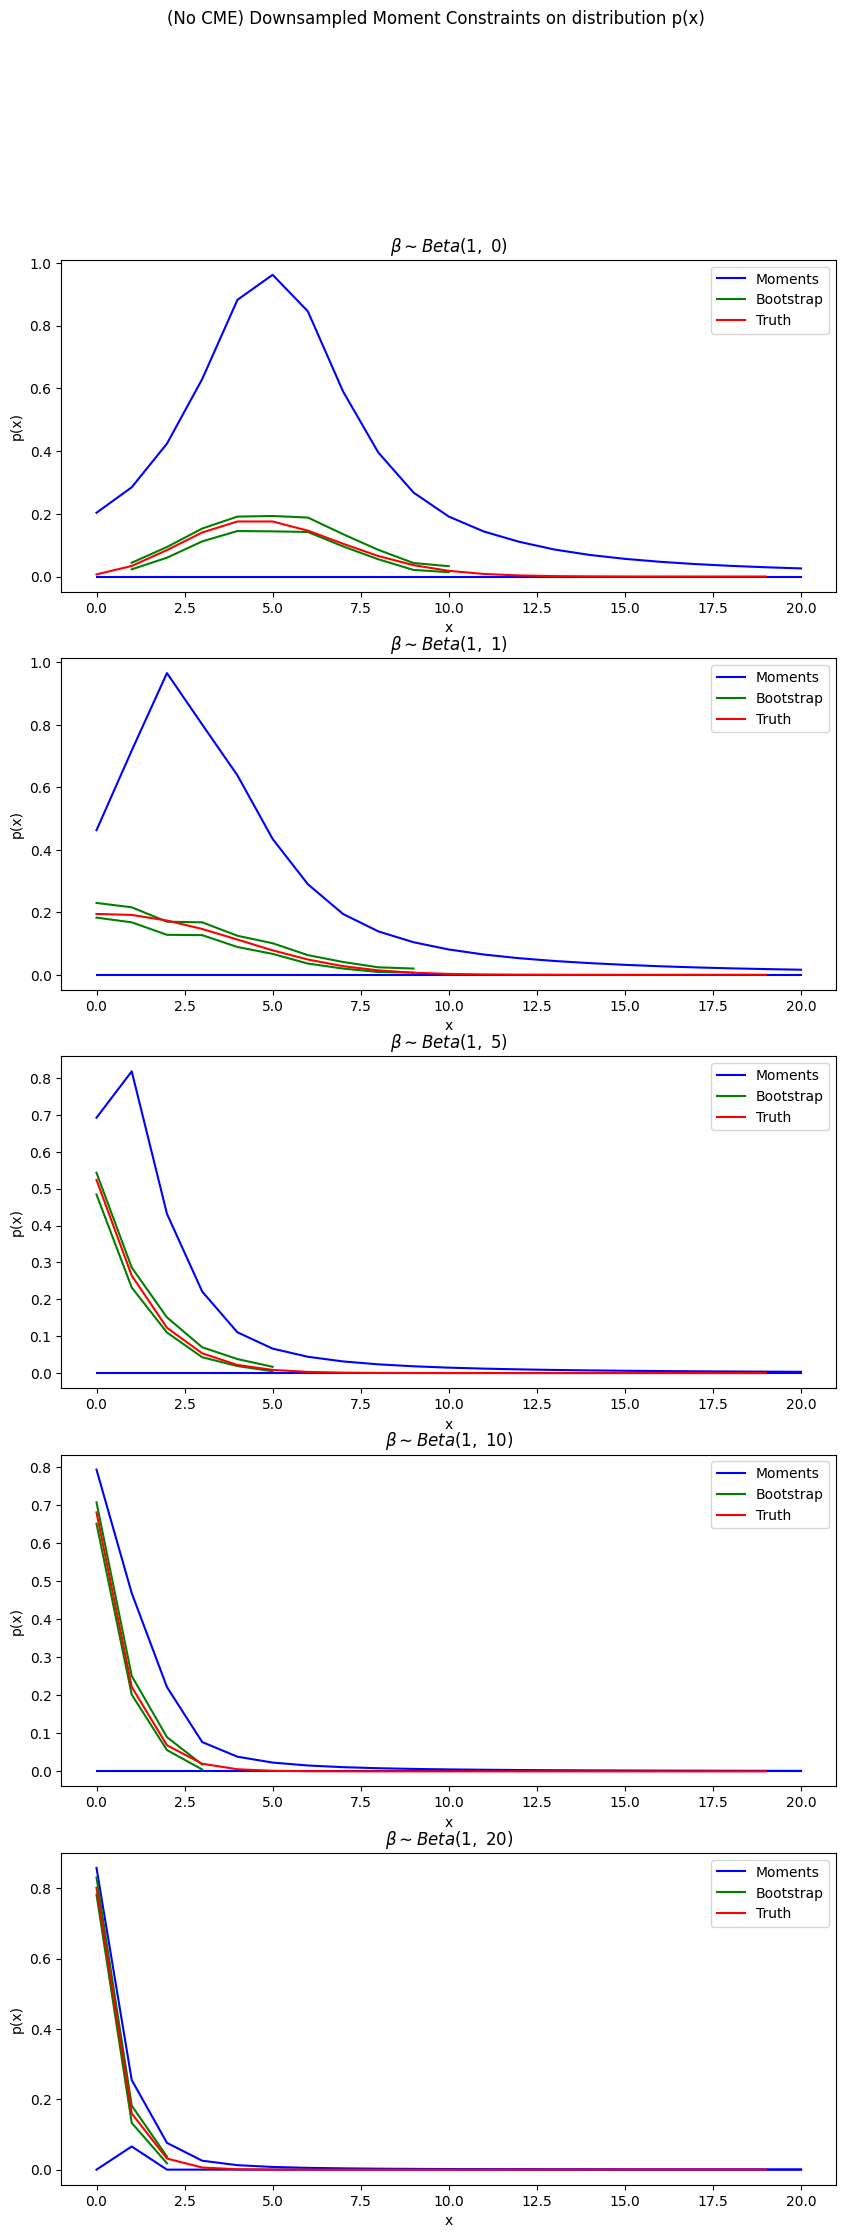

In [89]:
# settings
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# E[X] & E[X**2] optimization
for i, b in enumerate(bs):
    delta = ds[i]
    solution_moment_var = optimize_moment_downsampled_p(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True, CME=False)
    axs[i].plot(solution_moment_var['p'][:, 0], color="blue", label="Moments")
    axs[i].plot(solution_moment_var['p'][:, 1], color="blue")

    # probability bootstrap
    data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)
    data_downsampled = data.downsample("test", beta)
    data_downsampled.bootstrap_marginal_probabilities()
    lb = [x if x > 0 else None for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :]]
    ub = [x if x < 1 else None for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :]]
    axs[i].plot(lb, color="green", label="Bootstrap")
    axs[i].plot(ub, color="green")

    # true distribution
    p_OB = np.zeros(M)
    for betaj in beta:
        p_OB += scipy.stats.poisson.pmf([m for m in range(M)], betaj * k) / len(beta)
    axs[i].plot(p_OB, color="red", label="Truth")

    # plotting
    axs[i].set_title(r"$\beta \sim Beta(1,$ " + str(b) + r"$)$")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("p(x)")
    axs[i].legend()

plt.suptitle("(No CME) Downsampled Moment Constraints on distribution p(x)")

Overall the bounds on $p^{OB}$ from downsampled moment optimization are worse than the bootstrap, having mostly zero lower bounds and upper bounds high above the true distribution.

However, for lower capture efficiency the bounds tighten, even producing some non-zero lower bounds: this is not enough to beat the bootstrap but it is interesting how the moments handle capture efficiency very well.

## (CME) Moment -> Probability

Now consider the same settings but including the CME constraints, to show the bounds produced in practice.

We know from above that the moments constrain probabilities weaker than the bootstrap, but is this equalised by adding CME constraints to the optimization?

And how do the results from moments + CME compare to probabilities + CME?

In [139]:
# settings
k = 2
b = 0

# simulate data
data = simulation.simulate_dataset_range_BD("test", [0], rate=k)

# simulate capture
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)

# downsampled data
dataset = data.downsample("test", beta)
dataset.bootstrap_marginal_probabilities()
dataset.bootstrap_marginal_fm()
#dataset.compute_probabilities()

# optimize (feasibility)
opt = optimization.Optimization(
    dataset,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    license_file="../../../WLS_credentials.json",
    print_solution=False,
    tqdm_disable=True
)

# re-optimize (bound k_tx)
sol = optimize_downsampled_p(opt, 0)

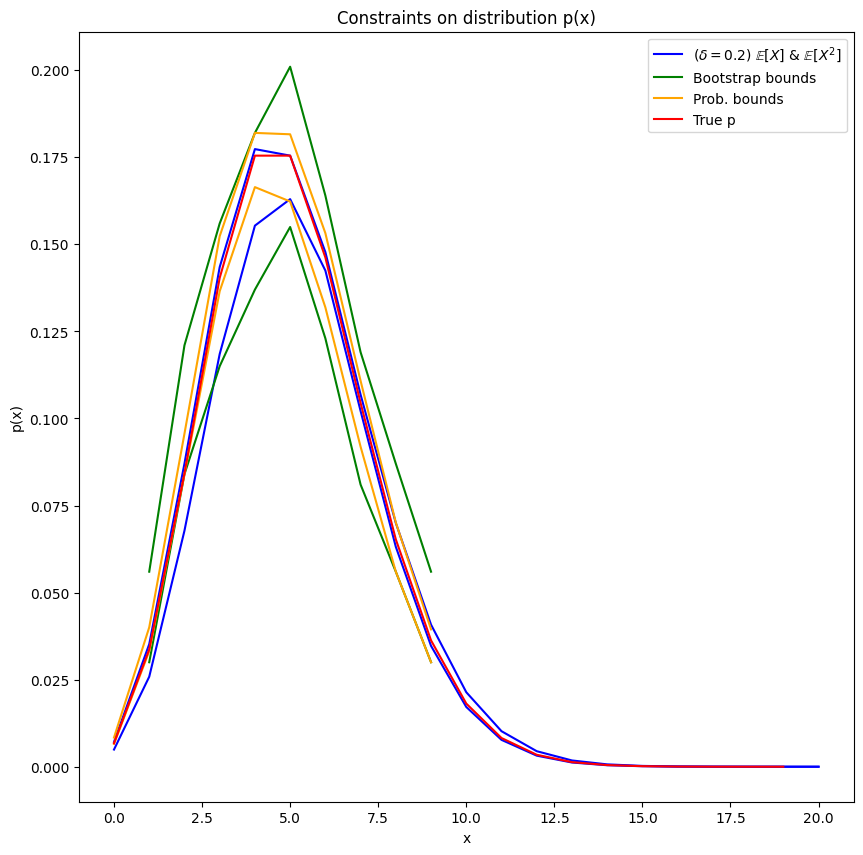

In [146]:
# settings
delta = 0.2
k = 5
M = 20
a = 1
b = 0

# plotting
fig, axs = plt.subplots(figsize=(10, 10))

# E[X] & E[X**2] optimization
solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=True)
axs.plot(solution_moment_var['p'][:, 0], color="blue", label=r"($\delta = 0.2$) $\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
axs.plot(solution_moment_var['p'][:, 1], color="blue")

# probability optimization
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
data.compute_probabilities()
lb = [x if x > 0 else None for x in data.probs_OB['sample-0']['x1_bounds'][0, :]]
ub = [x if x < 1 else None for x in data.probs_OB['sample-0']['x1_bounds'][1, :]]
axs.plot(lb, color="green", label="Bootstrap bounds")
axs.plot(ub, color="green")

# optimize (feasibility)
opt = optimization.Optimization(
    data,
    [
        "marginal_probability_1",
        "marginal_CME_1",
        "k_deg_1"
    ],
    license_file="../../../WLS_credentials.json",
    print_solution=False,
    tqdm_disable=True
)

# re-optimize (bound p(x))
sol = optimize_standard_p(opt, 0)

# plot
axs.plot(sol[0, :], color="orange", label="Prob. bounds")
axs.plot(sol[1, :], color="orange")

# true distribution
axs.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

For a typical moment interval width (at $\beta = 1$) of $\delta = 0.2$ we see that the bounds produced by moments are very tight to the true distribution, beating the bootstrap (green) to show the improvement from the No-CME case.

Additionally, the moment + CME bounds are generally tighter than the probability + CME bounds (orange), being slightly worse for the lower bounds on some places.

Overall this is very interesting, as it shows that the moments can enforce very tight bounds on the stationary distribution, clearly following the poisson model of the CME. 

### Capture efficiency $\beta$

#### $p^{OG}$ Moments vs True Distribution

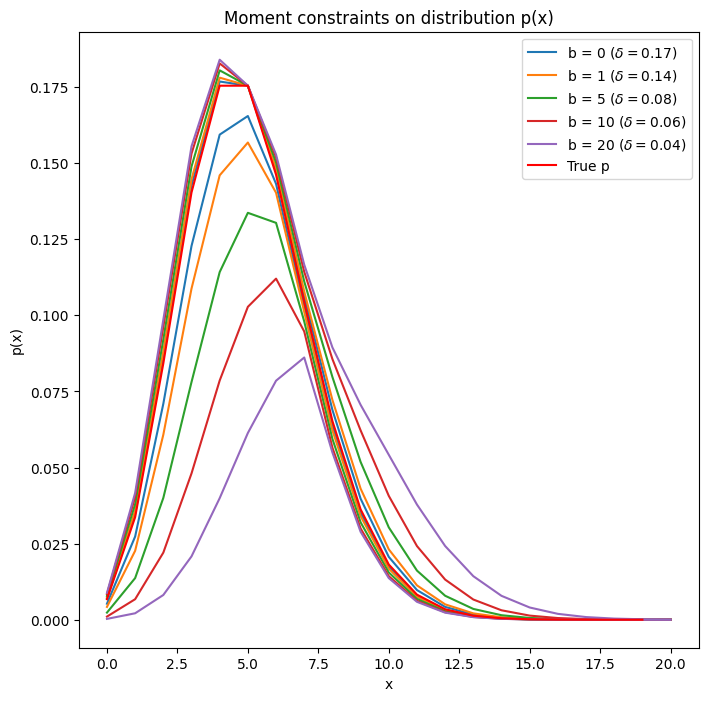

In [90]:
# settings
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plotting
fig, axs = plt.subplots(figsize=(8, 8))

# E[X] & E[X**2] optimization
for i, b in enumerate(bs):
    delta = ds[i]
    solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=True)
    axs.plot(solution_moment_var['p'][:, 0], color=f"C{i}", label=f"b = {b}" + r" ($\delta = $" + str(delta) + ")")
    axs.plot(solution_moment_var['p'][:, 1], color=f"C{i}")

# true distribution
axs.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

# plotting
axs.set_title("Moment constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

As capture efficiency drops, the upper bounds stay tight but the lower bounds drop off quite significantly.

___

FUTURE WORK: would like to compare this dropoff to probability + CME optimization to see if a similar pattern occurs, but the B-method handles capture efficiency poorly (memory errors, etc) so impractical.

In [ ]:
# settings
delta = 0.14
k = 5
M = 20
a = 1
b = 1

# plotting
fig, axs = plt.subplots(figsize=(10, 10))

# E[X] & E[X**2] optimization
solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, printing=False, var=True, CME=True)
axs.plot(solution_moment_var['p'][:, 0], color="blue", label=r"($\delta = 0.2$) $\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
axs.plot(solution_moment_var['p'][:, 1], color="blue")

# probability optimization
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)
data = data.downsample("test", beta)
data.bootstrap_marginal_probabilities()
#lb = [x if x > 0 else None for x in data.probs_OB['sample-0']['x1_bounds'][0, :]]
#ub = [x if x < 1 else None for x in data.probs_OB['sample-0']['x1_bounds'][1, :]]
#axs.plot(lb, color="green", label="Bootstrap bounds")
#axs.plot(ub, color="green")

# optimize (feasibility)
opt = optimization.Optimization(
    data,
    [
        "marginal_probability_1",
        "marginal_CME_1",
        "k_deg_1"
    ],
    license_file="../../../WLS_credentials.json",
    print_solution=False,
    tqdm_disable=True
)

# re-optimize (bound p(x))
sol = optimize_standard_p(opt, 0)

# plot
axs.plot(sol[0, :], color="orange", label="Prob. bounds")
axs.plot(sol[1, :], color="orange")

# true distribution
axs.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

#### $p^{OB}$ Downsampled Moments vs Bootstrap vs True Distribution

From the available results, overall bounds seem good, similar pattern to standard moment optimization. Definitely enforcing model structure.

___

Downsampled optimization of all p(x)'s too slow: likely the triple products in downsampled CME increase optimization time, this is not an issue for testing feasibility, but when optimizing for the minimum and maximum of each p(x), adds up to a significant slowdown (or could be another issue).

___

In [ ]:
# settings
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# E[X] & E[X**2] optimization
for i, b in enumerate(bs):
    delta = ds[i]
    solution_moment_var = optimize_moment_downsampled_p(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True, CME=True)
    axs[i].plot(solution_moment_var['p'][:, 0], color="blue", label="Moments")
    axs[i].plot(solution_moment_var['p'][:, 1], color="blue")

    # probability bootstrap
    '''
    data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)
    data_downsampled = data.downsample("test", beta)
    data_downsampled.bootstrap_marginal_probabilities()
    lb = [x if x > 0 else None for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :]]
    ub = [x if x < 1 else None for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :]]
    axs[i].plot(lb, color="green", label="Bootstrap")
    axs[i].plot(ub, color="green")
    '''

    # true distribution
    p_OB = np.zeros(M)
    for betaj in beta:
        p_OB += scipy.stats.poisson.pmf([m for m in range(M)], betaj * k) / len(beta)
    axs[i].plot(p_OB, color="red", label="Truth")

    # plotting
    axs[i].set_title(r"$\beta \sim Beta(1,$ " + str(b) + r"$)$")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("p(x)")
    axs[i].legend()

plt.suptitle("Downsampled Moment Constraints on distribution p(x)")

In [ ]:
# settings
delta = 0.14
k = 5
M = 20
a = 1
b = 1

# plotting
fig, axs = plt.subplots(figsize=(10, 10))

# E[X] & E[X**2] optimization
solution_moment_var = optimize_moment_downsampled_p(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True, CME=True)
axs.plot(solution_moment_var['p'][:, 0], color="blue", label=r"($\delta = 0.2$) $\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
axs.plot(solution_moment_var['p'][:, 1], color="blue")

# probability optimization
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
if b == 0:
    beta = np.ones(1000)
else:
    beta = rng.beta(1, b, size=1000)
data = data.downsample("test", beta)
data.bootstrap_marginal_probabilities()
data.bootstrap_marginal_fm()
#lb = [x if x > 0 else None for x in data.probs_OB['sample-0']['x1_bounds'][0, :]]
#ub = [x if x < 1 else None for x in data.probs_OB['sample-0']['x1_bounds'][1, :]]
#axs.plot(lb, color="green", label="Bootstrap bounds")
#axs.plot(ub, color="green")

# optimize (feasibility)
opt = optimization.Optimization(
    data,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    license_file="../../../WLS_credentials.json",
    print_solution=False,
    tqdm_disable=True
)

# re-optimize (bound p(x))
sol = optimize_downsampled_p(opt, 0)

# plot
axs.plot(sol[0, :], color="orange", label="Prob. bounds")
axs.plot(sol[1, :], color="orange")

# true distribution
p_OB = np.zeros(M)
for betaj in beta:
    p_OB += scipy.stats.poisson.pmf([m for m in range(M)], betaj * k) / len(beta)
axs.plot(p_OB, color="red", label="True p")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

## Non-poisson moments

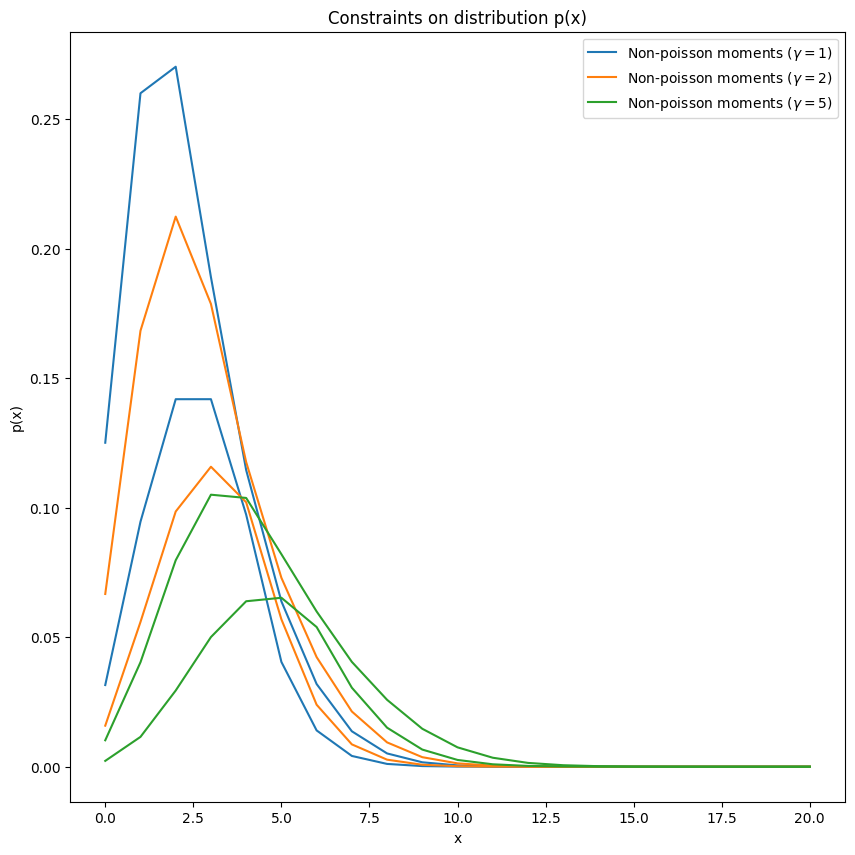

In [156]:
# settings
delta = 0.2
k = 2
M = 20
a = 1
b = 0

# plotting
fig, axs = plt.subplots(figsize=(10, 10))

# non-poisson moments: gamma bias
for i, gamma in enumerate([1, 2, 5]):

    solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, gamma=gamma, printing=False, var=True, CME=True)
    axs.plot(solution_moment_var['p'][:, 0], color=f"C{i}", label=r"Non-poisson moments ($\gamma = $" + f"{gamma})")
    axs.plot(solution_moment_var['p'][:, 1], color=f"C{i}")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

From the results of non-poisson moment tests during parameter optimization we know that for $\gamma > 0$ the optimization bounds simply center around the wrong parameter as $\gamma$ increases, and we see here that this is reflected in the distribution: as $\gamma$ increases, the distribution bounds follow a poisson distribution of increasing (wrong) parameter value. For $\gamma < 0$ the optimization is of course infeasible (objective function doesn't change this, parameter or probability alike).

Overall, suggests that only underdispersion ($\gamma < 0$: mean > var) and not overdispersion ($\gamma > 0$: mean < var) causes infeasibility. Unfortunately, interaction appears to causes overdispersion in poisson data, and may be the reason for the lack of infeasibility in moment + CME optimization tests.

See 'distribution_effects' for discussion of effects of interaction, telegraph and capture efficiency on the mean = var assumption, and 'dispersion_test' for (in)feasibility results for (under/over)dispersed data.

### Fixed parameter $k$

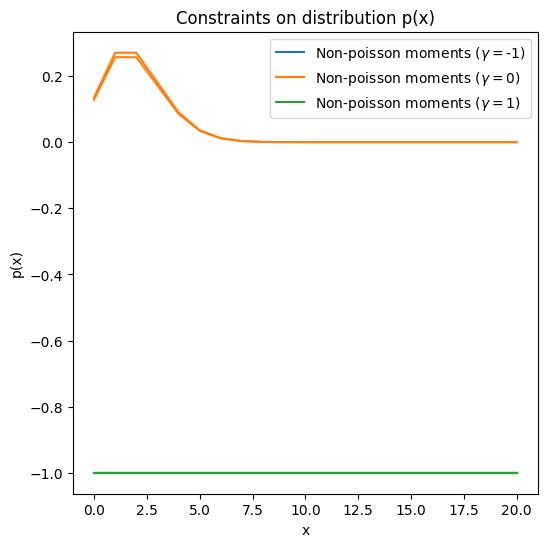

In [161]:
# settings
delta = 0.2
k = 2
M = 20
a = 1
b = 0

# plotting
fig, axs = plt.subplots(figsize=(6, 6))

# non-poisson moments: gamma bias
for i, gamma in enumerate([-1, 0, 1]):

    solution_moment_var = optimize_moment_p(M, k, a, b, delta, 30 * delta**2, gamma=gamma, printing=False, var=True, CME=True, ktx=k)
    axs.plot(solution_moment_var['p'][:, 0], color=f"C{i}", label=r"Non-poisson moments ($\gamma = $" + f"{gamma})")
    axs.plot(solution_moment_var['p'][:, 1], color=f"C{i}")

# plotting
axs.set_title("Constraints on distribution p(x)")
axs.set_xlabel("x")
axs.set_ylabel("p(x)")
plt.legend()

Fixing the parameter means that any $\gamma \ne 0$ is infeasible: by removing the quadratic terms in the CME and reducing to a linear system of equations the constraints become tight enough that only poisson probabilities remain feasible.

Unfortunately we do not know the paramter value in practice, and of course if the data is non-poisson then there is no poisson parameter.

## Probability -> Moment bounds

Consider using probability bootstrap intervals as input and optimizing for bounds on moments (both OB and OG):

$$ \sum \limits_{x=0}^{M} xp(x) \quad , \quad \sum \limits_{x=0}^{M} x^{2}p(x) $$

May show if the probabilities carry more information about the data than moments, if bounds produced are the same or better than input moments.

In [18]:
from interaction_inference import simulation, optimization, constraints

In [19]:
def optimize_standard_moment(self, i, var=False, cb=False):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize distribution, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            Ex = gp.quicksum(variables['p1'] * np.arange(self.overall_extent_OG[f'sample-{i}']['max_x1_OG'] + 1))
            if var:
                Ex2 = gp.quicksum(variables['p1'] * np.arange(self.overall_extent_OG[f'sample-{i}']['max_x1_OG'] + 1)**2)
            if cb:
                Ex3 = gp.quicksum(variables['p1'] * np.arange(self.overall_extent_OG[f'sample-{i}']['max_x1_OG'] + 1)**3)

            # solution
            solution = {}

            # E[X]
            model.setObjective(Ex, GRB.MINIMIZE)
            model.optimize()
            try:
                Ex_min = model.ObjVal
            except:
                Ex_min = None

            model.setObjective(Ex, GRB.MAXIMIZE)
            model.optimize()
            try:
                Ex_max = model.ObjVal
            except:
                Ex_max = None

            solution['Ex_min'] = Ex_min
            solution['Ex_max'] = Ex_max

            # E[X**2]
            if var:
                model.setObjective(Ex2, GRB.MINIMIZE)
                model.optimize()
                try:
                    Ex2_min = model.ObjVal
                except:
                    Ex2_min = None

                model.setObjective(Ex2, GRB.MAXIMIZE)
                model.optimize()
                try:
                    Ex2_max = model.ObjVal
                except:
                    Ex2_max = None

                solution['Ex2_min'] = Ex2_min
                solution['Ex2_max'] = Ex2_max

            # E[X**3]
            if cb:
                model.setObjective(Ex3, GRB.MINIMIZE)
                model.optimize()
                try:
                    Ex3_min = model.ObjVal
                except:
                    Ex3_min = None

                model.setObjective(Ex3, GRB.MAXIMIZE)
                model.optimize()
                try:
                    Ex3_max = model.ObjVal
                except:
                    Ex3_max = None

                solution['Ex3_min'] = Ex3_min
                solution['Ex3_max'] = Ex3_max
                
    return solution

In [20]:
def optimize_downsampled_moment(self, i, var=False, cb=False):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize distribution, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            Ex = gp.quicksum(variables['pd1'] * np.arange(self.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1))
            if var:
                Ex2 = gp.quicksum(variables['pd1'] * np.arange(self.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1)**2)
            if cb:
                Ex3 = gp.quicksum(variables['pd1'] * np.arange(self.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1)**3)

            # solution
            solution = {}

            # E[X]
            model.setObjective(Ex, GRB.MINIMIZE)
            model.optimize()
            try:
                Ex_min = model.ObjVal
            except:
                Ex_min = None

            model.setObjective(Ex, GRB.MAXIMIZE)
            model.optimize()
            try:
                Ex_max = model.ObjVal
            except:
                Ex_max = None

            solution['Ex_min'] = Ex_min
            solution['Ex_max'] = Ex_max

            # E[X**2]
            if var:
                model.setObjective(Ex2, GRB.MINIMIZE)
                model.optimize()
                try:
                    Ex2_min = model.ObjVal
                except:
                    Ex2_min = None

                model.setObjective(Ex2, GRB.MAXIMIZE)
                model.optimize()
                try:
                    Ex2_max = model.ObjVal
                except:
                    Ex2_max = None

                solution['Ex2_min'] = Ex2_min
                solution['Ex2_max'] = Ex2_max
            
            # E[X**3]
            if cb:
                model.setObjective(Ex3, GRB.MINIMIZE)
                model.optimize()
                try:
                    Ex3_min = model.ObjVal
                except:
                    Ex3_min = None

                model.setObjective(Ex3, GRB.MAXIMIZE)
                model.optimize()
                try:
                    Ex3_max = model.ObjVal
                except:
                    Ex3_max = None

                solution['Ex3_min'] = Ex3_min
                solution['Ex3_max'] = Ex3_max

    return solution

In [ ]:
# settings
k = 2

# probability optimization
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
data.compute_probabilities()
data.compute_moments()

# optimize (feasibility)
opt = optimization.Optimization(
    data,
    [
        "marginal_probability_1",
        "marginal_CME_1",
        "k_deg_1"
    ],
    license_file="../../../WLS_credentials.json",
    print_solution=False,
    tqdm_disable=True
)

# re-optimize (bound p(x))
sol = optimize_standard_moment(opt, 0, var=True, cb=True)

# deltas
delta = sol['Ex_max'] - sol['Ex_min']
deltasq = sol['Ex2_max'] - sol['Ex2_min']
deltacb = sol['Ex3_max'] - sol['Ex3_min']

# display
print("Optimization:\n")
print(f"E[X] in ({sol['Ex_min']}, {sol['Ex_max']})")
print(f"E[X**2] in ({sol['Ex2_min']}, {sol['Ex2_max']})")
print(f"E[X**3] in ({sol['Ex3_min']}, {sol['Ex3_max']})")
print("")
print(f"delta = {delta}")
print(f"deltasq = {deltasq}")
print(f"deltacb = {deltacb}")

# moments from boostrap
moms = data.moments_OB['sample-0']
deltaM = moms['E_x1'][1] - moms['E_x1'][0]
deltasqM = moms['E_x1_sq'][1] - moms['E_x1_sq'][0]

print("\nMoment Bootstrap:\n")
print(f"E[X] in ({moms['E_x1'][0]}, {moms['E_x1'][1]})")
print(f"E[X**2] in ({moms['E_x1_sq'][0]}, {moms['E_x1_sq'][1]})")
print("")
print(f"delta = {deltaM}")
print(f"deltasq = {deltasqM}")

Optimization:

E[X] in (1.695875, 2.21105)
E[X**2] in (4.829375, 6.965299999999999)
E[X**3] in (16.254875, 25.828400000000002)

delta = 0.5151750000000002
deltasq = 2.1359249999999994
deltacb = 9.573525000000004

Moment Bootstrap:

E[X] in (1.945975, 2.1270249999999997)
E[X**2] in (5.687925, 6.678025)

delta = 0.1810499999999997
deltasq = 0.9901


See that the probability -> moment optimization bounds are tighter than those from the moment bootstrap, giving smaller deltas, although the lower bounds are worse.

Should note that the probability -> moment bounds are much weaker than moment bootstrap when CME constraints are not used.

### Capture efficiency $\beta$

In [85]:
rng = np.random.default_rng()

In [87]:
# settings
k = 2

# simulate
data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)

# downsampled
for b in [0, 1, 5, 10, 20]:

    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)
    dataset = data.downsample("test", beta)
    dataset.bootstrap_marginal_probabilities()
    dataset.bootstrap_marginal_fm()
    dataset.compute_moments()

    # optimize (feasibility)
    opt = optimization.Optimization(
        dataset,
        [
            "downsampled_marginal_probability_1",
            "downsampled_marginal_CME_1",
            "k_deg_1"
        ],
        license_file="../../../WLS_credentials.json",
        print_solution=False,
        tqdm_disable=True
    )

    # re-optimize (bound p(x))
    sol = optimize_downsampled_moment(opt, 0, var=True)

    # deltas
    delta = sol['Ex_max'] - sol['Ex_min']
    deltasq = sol['Ex2_max'] - sol['Ex2_min']

    # display
    print(f"\nb = {b}\n")

    print("Optimization:\n")
    print(f"E[X] in ({sol['Ex_min']}, {sol['Ex_max']})")
    print(f"E[X**2] in ({sol['Ex2_min']}, {sol['Ex2_max']})")
    print("")
    print(f"delta = {delta}")
    print(f"deltasq = {deltasq}")

    # moments from boostrap
    moms = dataset.moments_OB['sample-0']
    deltaM = moms['E_x1'][1] - moms['E_x1'][0]
    deltasqM = moms['E_x1_sq'][1] - moms['E_x1_sq'][0]

    print("\nMoment Bootstrap:\n")
    print(f"E[X] in ({moms['E_x1'][0]}, {moms['E_x1'][1]})")
    print(f"E[X**2] in ({moms['E_x1_sq'][0]}, {moms['E_x1_sq'][1]})")
    print("")
    print(f"delta = {deltaM}")
    print(f"deltasq = {deltasqM}")


b = 0

Optimization:

E[X] in (1.7964542606882343, 1.9825074187197358)
E[X**2] in (5.165419021309795, 5.813997714784788)

delta = 0.18605315803150146
deltasq = 0.6485786934749935

Moment Bootstrap:

E[X] in (1.889975, 2.063)
E[X**2] in (5.544975, 6.5112)

delta = 0.1730250000000002
deltasq = 0.9662249999999997

b = 1

Optimization:

E[X] in (0.8156017427887701, 0.9888826815999349)
E[X**2] in (1.6819711546846832, 2.1336508775990013)

delta = 0.1732809388111648
deltasq = 0.4516797229143181

Moment Bootstrap:

E[X] in (0.884975, 1.021)
E[X**2] in (1.88275, 2.358025)

delta = 0.13602499999999995
deltasq = 0.4752750000000001

b = 5

Optimization:

E[X] in (0.24984246380587133, 0.34399999296567935)
E[X**2] in (0.31368491412004085, 0.4539999932171488)

delta = 0.09415752915980802
deltasq = 0.14031507909710794

Moment Bootstrap:

E[X] in (0.284975, 0.361)
E[X**2] in (0.39095, 0.548)

delta = 0.07602500000000001
deltasq = 0.15705000000000002

b = 10

Optimization:

E[X] in (0.1466376106712611,

Overall the moment bootstrap and probability -> moment optimization produce very similar bounds.

# Future work

- Display probability -> moments vs moment bootstrap comparison in a plot for easier understanding
- Compute only marginal information to allow comparisons of probability B-method with moments
- Investigate slow speed of downsampled distribution optimization

___

- add constraints directly relating moments to reaction rates

e.g.
\begin{align*}
& \mathbb{E}[X_{OB}] = k_{tx} \mathbb{E}[\beta] \\
& \mathbb{E}[X^{2}_{OB}] = \ldots
\end{align*}
___

# Appendix

## Old Work

In [59]:
from interaction_inference import simulation
rng = np.random.default_rng()

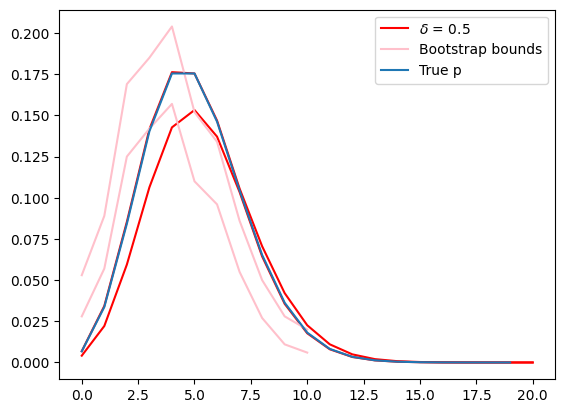

In [67]:
deltas = [0.5] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["red", "blue", "green", "orange", "black"]

for i, delta in enumerate(deltas):
    solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True)
    plt.plot(solution_moment_var['p'][:, 0], color=colours[i], label=r"$\delta$ = " + str(delta))
    plt.plot(solution_moment_var['p'][:, 1], color=colours[i])

data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=5)
#beta = rng.beta(a, b, size=1000)
data_downsampled = data# data.downsample("test", beta)
data_downsampled.bootstrap_marginal_probabilities()

lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

plt.plot(lb, color="pink", label="Bootstrap bounds")
plt.plot(ub, color="pink")

plt.plot(scipy.stats.poisson.pmf(range(20), k), label="True p")

plt.legend()

## Constraints on p(x) very wide given just moment intervals

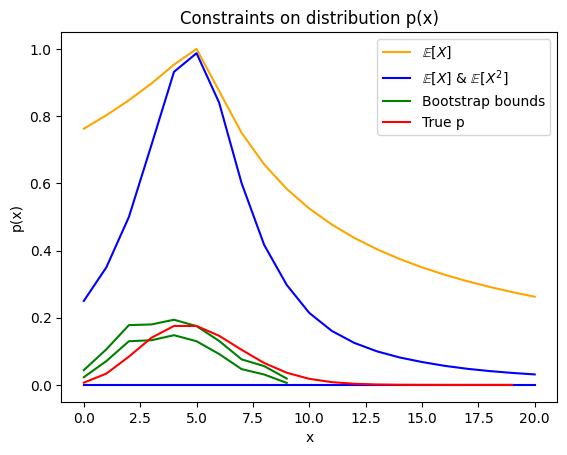

In [86]:
deltas = [0.25] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["orange", "blue", "green", "orange", "black"]

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=False, CME=False)
plt.plot(solution_moment_var['p'][:, 0], color=colours[0], label=r"$\mathbb{E}[X]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[0])

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True, CME=False)
plt.plot(solution_moment_var['p'][:, 0], color=colours[1], label=r"$\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[1])

data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
#beta = rng.beta(a, b, size=1000)
data_downsampled = data# data.downsample("test", beta)
data_downsampled.bootstrap_marginal_probabilities()

lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

plt.plot(lb, color="green", label="Bootstrap bounds")
plt.plot(ub, color="green")

plt.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

plt.title("Constraints on distribution p(x)")
plt.xlabel("x")
plt.ylabel("p(x)")

plt.legend()

## Poisson distribution still feasible given non-poisson moment intervals

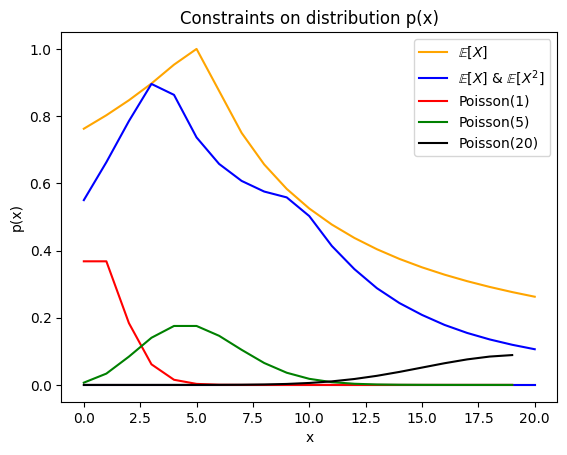

In [85]:
deltas = [0.25] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["orange", "blue", "green", "orange", "black"]

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=False, CME=False, gamma=1)
plt.plot(solution_moment_var['p'][:, 0], color=colours[0], label=r"$\mathbb{E}[X]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[0])

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True, CME=False, gamma=20)
plt.plot(solution_moment_var['p'][:, 0], color=colours[1], label=r"$\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[1])

#data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
#beta = rng.beta(a, b, size=1000)
#data_downsampled = data# data.downsample("test", beta)
#data_downsampled.bootstrap_marginal_probabilities()

#lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
#ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

#plt.plot(lb, color="green", label="Bootstrap bounds")
#plt.plot(ub, color="green")


plt.plot(scipy.stats.poisson.pmf(range(20), 1), color="red", label="Poisson(1)")
plt.plot(scipy.stats.poisson.pmf(range(20), 5), color="green", label="Poisson(5)")
plt.plot(scipy.stats.poisson.pmf(range(20), 20), color="black", label="Poisson(20)")

plt.title("Constraints on distribution p(x)")
plt.xlabel("x")
plt.ylabel("p(x)")

plt.legend()

## Realistic $\delta$ values

Simulate data from birth-death model and bootstrap moments to get typical widths of intervals

In [98]:
from interaction_inference import simulation

In [99]:
rng = np.random.default_rng()

In [ ]:
delta_dict = {}
for k in [1, 2, 5]:
    dataset = simulation.simulate_dataset_range_BD("test", [0 for j in range(5)], rate=k, tqdm_disable=False)
    for b in [0, 1, 5, 10, 20]:
        if b == 0:
            beta = np.ones(1000)
        else:
            beta = rng.beta(1, b, size=1000)
        dataset_downsampled = dataset.downsample("test", beta)
        dataset_downsampled.compute_moments(tqdm_disable=False)

        deltas = []
        deltas_sq = []
        for sample, moments in dataset_downsampled.moments_OB.items():
            d1 = moments['E_x1'][1] - moments['E_x1'][0]
            d2 = moments['E_x2'][1] - moments['E_x2'][0]
            ds1 = moments['E_x1_sq'][1] - moments['E_x1_sq'][0]
            ds2 = moments['E_x2_sq'][1] - moments['E_x2_sq'][0]

            deltas.append(d1)
            deltas.append(d2)
    
            deltas_sq.append(ds1)
            deltas_sq.append(ds2)

        delta_dict[(k, b)] = {
            'deltas': deltas,
            'deltas_sq': deltas_sq
        }

100%|██████████| 5/5 [00:00<00:00, 26.25it/s]


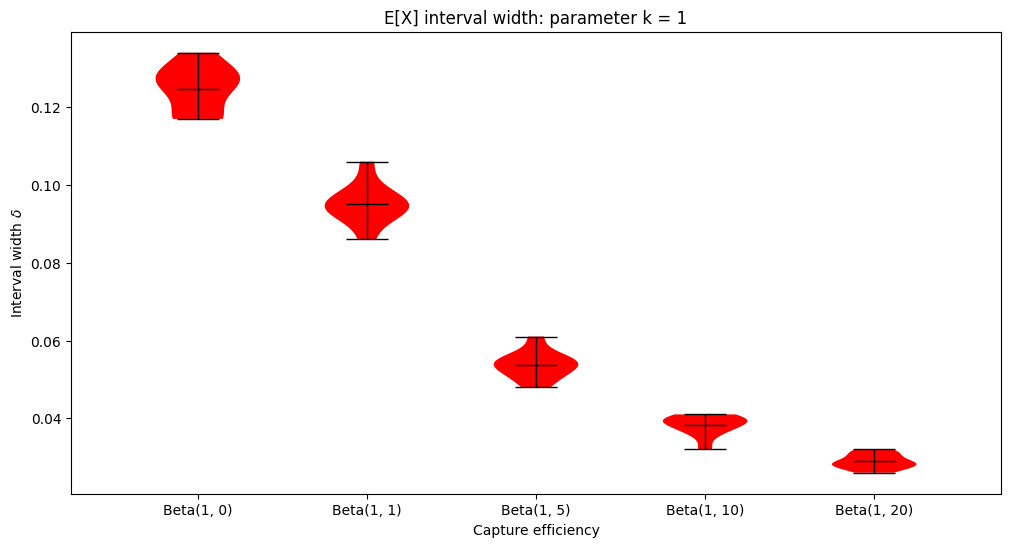

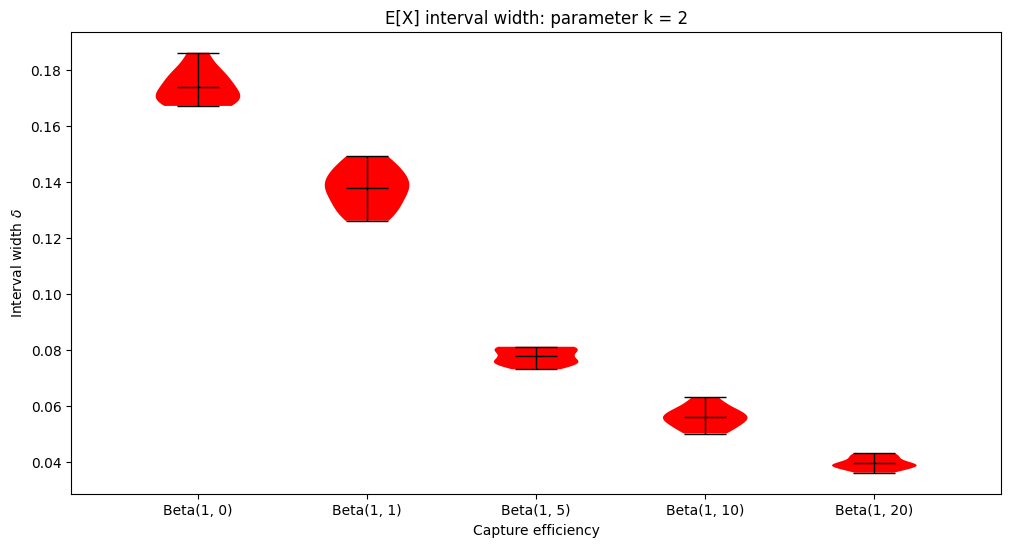

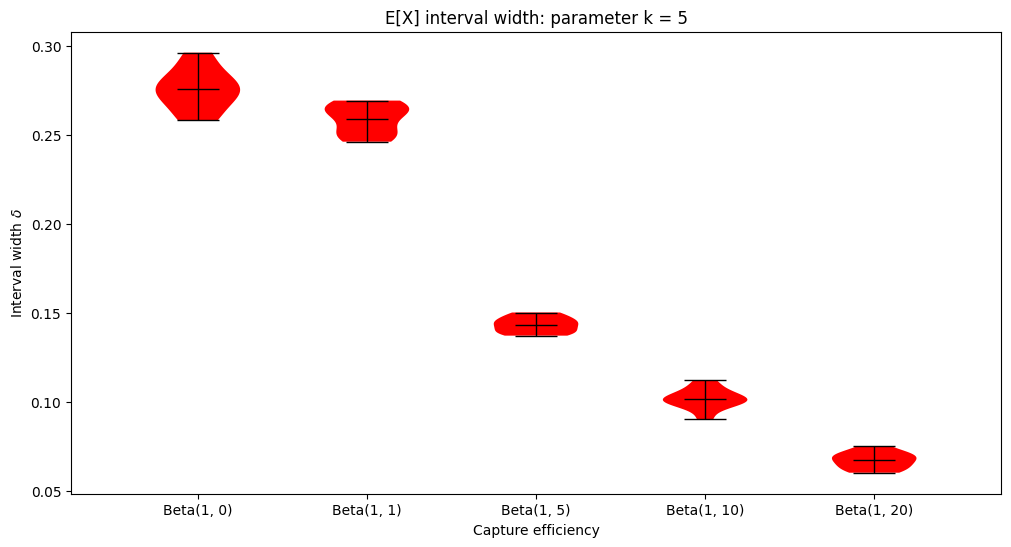

In [159]:
for k in [1, 2, 5]:

    delta_plot = [[float(x) for x in delta_dict[(k, b)]['deltas']] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        delta_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'E[X] interval width: parameter k = {k}')

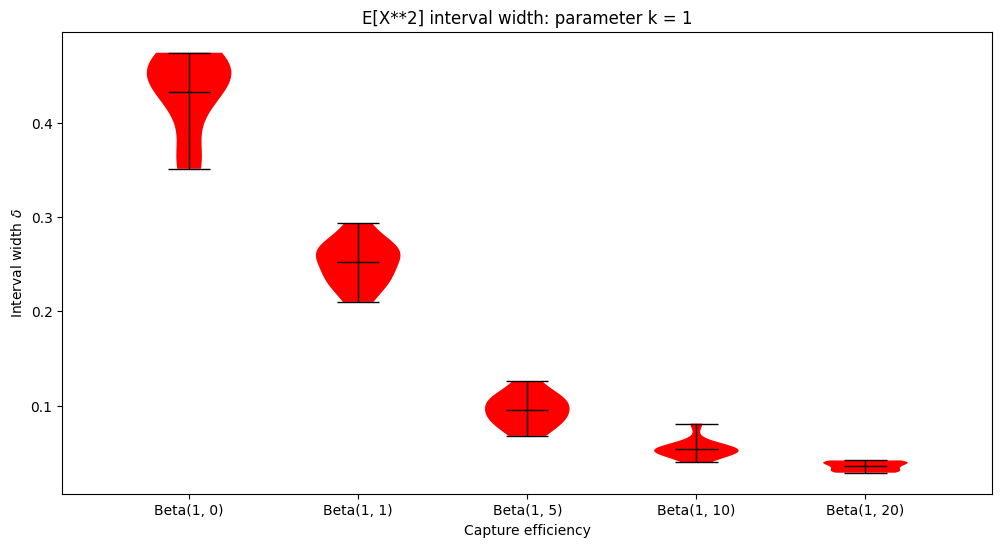

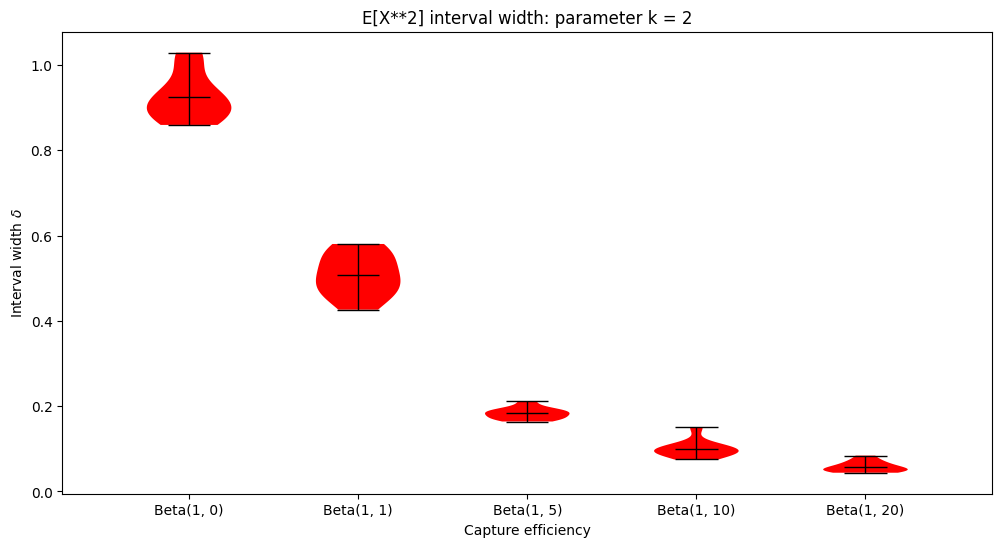

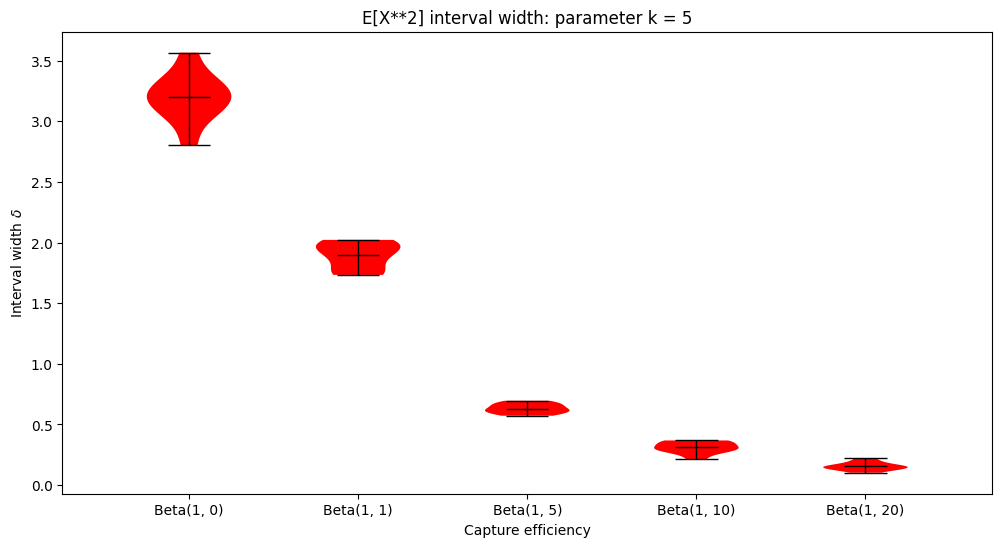

In [160]:
for k in [1, 2, 5]:

    delta_plot = [[float(x) for x in delta_dict[(k, b)]['deltas_sq']] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        delta_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'E[X**2] interval width: parameter k = {k}')

Text(0, 0.5, 'Width')

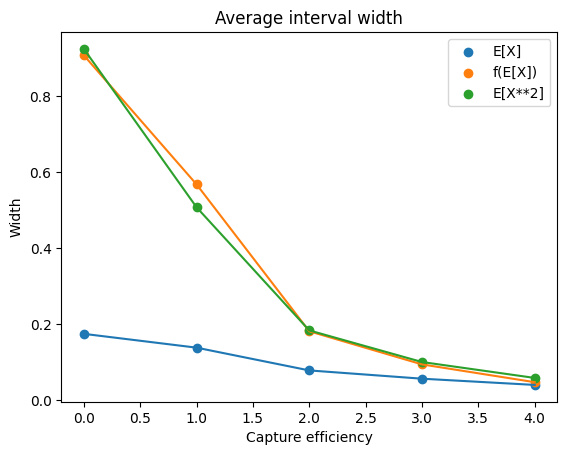

In [198]:
k = 2
dmeans = []
dsqmeans = []
for b in [0, 1, 5, 10, 20]:
    deltas = delta_dict[(k, b)]['deltas']
    deltas_sq = delta_dict[(k, b)]['deltas_sq']
    
    dmeans.append(np.mean(deltas))
    dsqmeans.append(np.mean(deltas_sq))

adj = [30 * x**2 for x in dmeans]

plt.plot(dmeans)
plt.scatter(range(5), dmeans, label="E[X]")
plt.plot(adj)
plt.scatter(range(5), adj, label="f(E[X])")
plt.plot(dsqmeans)
plt.scatter(range(5), dsqmeans, label="E[X**2]")
plt.legend()
plt.title("Average interval width")
plt.xlabel("Capture efficiency")
plt.ylabel("Width")

In [201]:
# deltas
dmeans

[np.float64(0.17393),
 np.float64(0.13754999999999998),
 np.float64(0.07761),
 np.float64(0.05581499999999999),
 np.float64(0.03941)]

### 1st vs 2nd moment widths

Want to input bounds about 1st and 2nd moments, but see from the plot above that the average width of bootstrap intervals is very different for the two moments.

A function of $f(x) = 30 x^2$ mapping the width of the 1st moment interval to the width of the 2nd seems to map well across a range of capture efficiencies, so can use $\delta$ and $30 \delta^2$ as respective widths about true values for testing.

Also see that the range of $\delta$ seen is around $[0, 0.2]$, so focus on a range similar to this.

(NOTE: relationship differs for different parameters, choose to focus on k = 2)


### $f_{m}$ widths

In [234]:
fm_dict = {}
for k in [1, 2, 5]:
    dataset = simulation.simulate_dataset_range_BD("test", [0 for j in range(5)], rate=k, tqdm_disable=False)
    for b in [0, 1, 5, 10, 20]:
        if b == 0:
            beta = np.ones(1000)
        else:
            beta = rng.beta(1, b, size=1000)
        dataset_downsampled = dataset.downsample("test", beta)
        dataset_downsampled.bootstrap_marginal_fm(tqdm_disable=False)

        fms = []
        for sample, moments in dataset_downsampled.fm_OB.items():
            f1 = moments['fm1'][1] - moments['fm1'][0]
            f2 = moments['fm2'][1] - moments['fm2'][0]

            fms = fms + list(f1)
            fms = fms + list(f2)

        fm_dict[(k, b)] = fms

100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


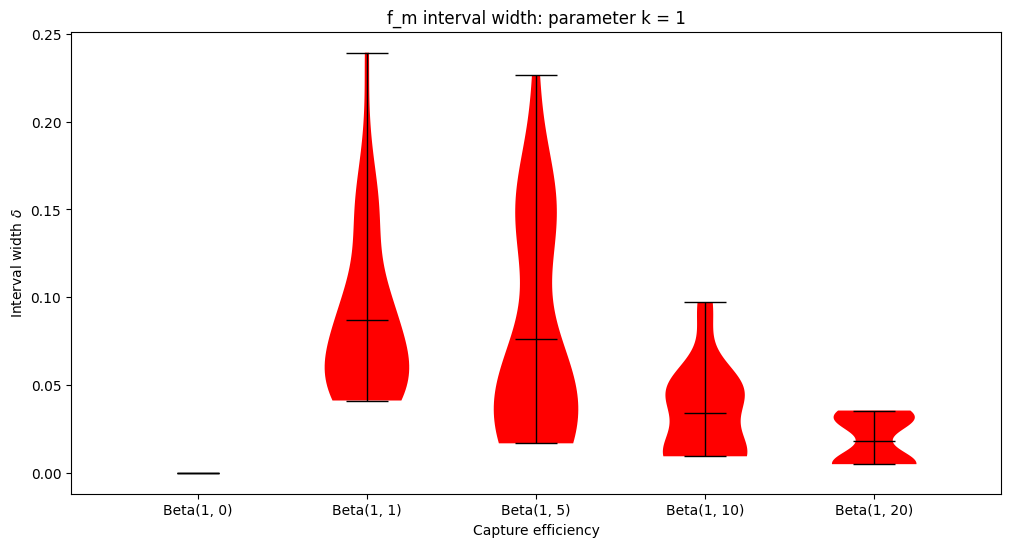

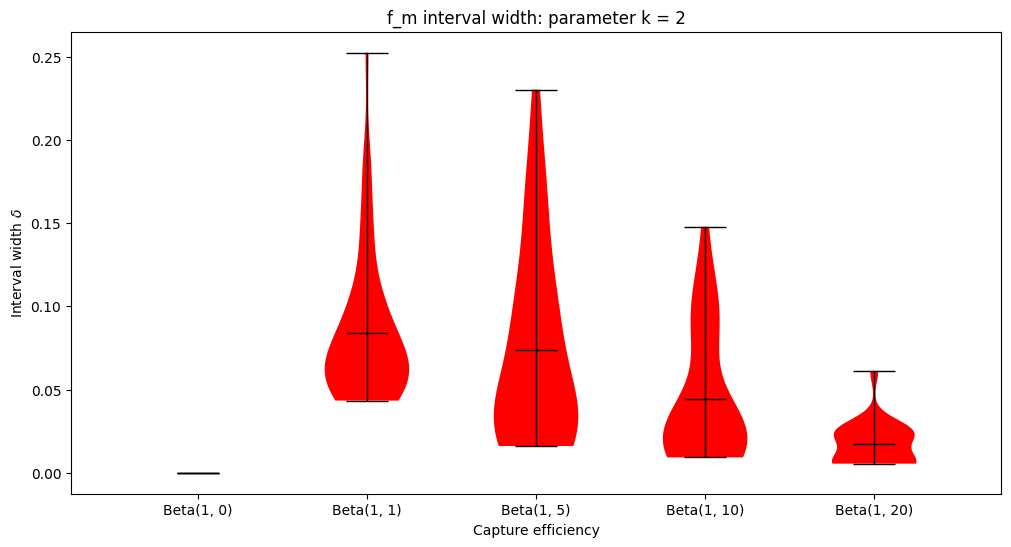

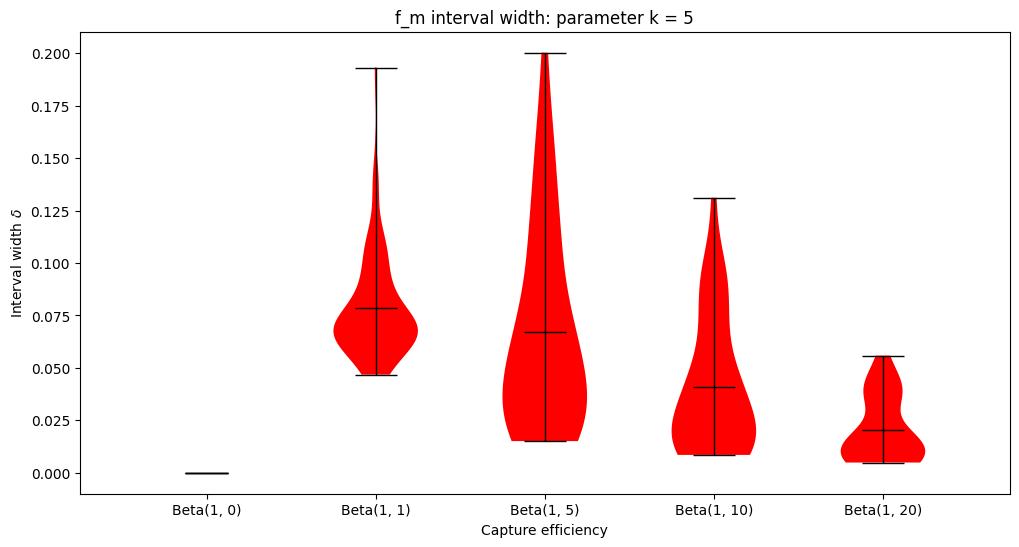

In [240]:
for k in [1, 2, 5]:

    # remove widths = 1
    fm_plot = [[float(x) for x in fm_dict[(k, b)] if not (x == 1)] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        fm_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'f_m interval width: parameter k = {k}')

Text(0, 0.5, 'Width')

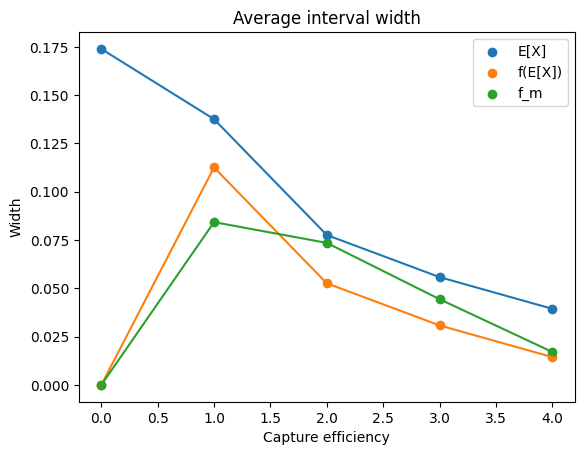

In [278]:
k = 2
dmeans = []
fmeans = []
for b in [0, 1, 5, 10, 20]:
    deltas = delta_dict[(k, b)]['deltas']
    fms = [float(x) for x in fm_dict[(k, b)] if not (x == 1)]
    
    dmeans.append(np.mean(deltas))
    fmeans.append(np.mean(fms))

adj = [x - 0.025 for x in dmeans]#[x - 3*(x**2) for x in dmeans]
adj[0] = 0

plt.plot(dmeans)
plt.scatter(range(5), dmeans, label="E[X]")
plt.plot(adj)
plt.scatter(range(5), adj, label="f(E[X])")
plt.plot(fmeans)
plt.scatter(range(5), fmeans, label="f_m")
plt.legend()
plt.title("Average interval width")
plt.xlabel("Capture efficiency")
plt.ylabel("Width")

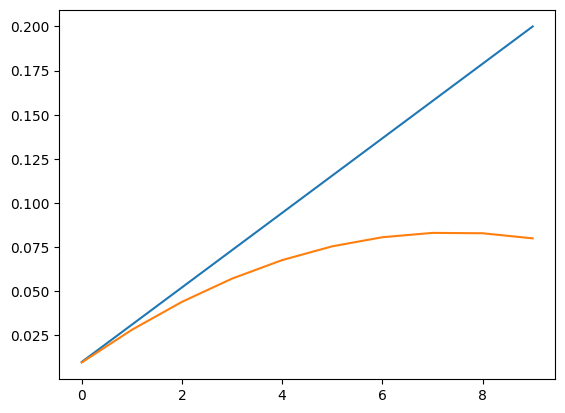

In [274]:
x = np.linspace(0.01, 0.2, 10)
plt.plot(x)
plt.plot(x - 3*(x**2))

### 1st moment vs $f_{m}$ widths

Want to input bounds about $f_{m}$ values, but see from the plot above that the average width of moment bootstrap intervals is quite different from that of the downsampled rates.

A function of $f(x) = 30 x^2$ mapping the width of the 1st moment interval to the width of the 2nd seems to map well across a range of capture efficiencies, so can use $\delta$ and $30 \delta^2$ as respective widths about true values for testing.

Also see that the range of $\delta$ seen is around $[0, 0.2]$, so focus on a range similar to this.

(NOTE: relationship differs for different parameters, choose to focus on k = 2)


## Exact $f_{m}$ computation

$$ f_{m} = \mathbb{E}[\beta \vert m] $$

Approximate by sample mean of $\{\beta_{j}\}_{j=1}^{n}$ :

$$ f_{m}\approx\frac{\sum\limits_{j=1}^{n}\beta_{j}^{m+1}e^{-\beta_{j}k_{tx}}}{\sum\limits_{j=1}^{n}\beta_{j}^{m}e^{-\beta_{j}k_{tx}}}$$

Exact formula for $m \sim Poi(k)$ and $\beta \sim Beta(a, b)$ case:

$$ f_{m} = \frac{\Gamma(b + m + a)}{\Gamma(m + a)} \frac{\Gamma(m + a + 1)}{\Gamma(b + m + a + 1)} \frac{M(m + a + 1, b + m + a + 1, -k)}{M(m + a, b + m + a, -k)} $$

Where $M(x, y, z)$ is Kummer's confluent hypergeometric function

In [37]:
# generator
rng = np.random.default_rng(319)

# settings
m = 10
k = 1
a = 1
b = 2
n = 100000

# large sample of capture efficiencies
beta = rng.beta(a, b, size=n)

# estimated fm
expr = beta**m * np.exp(-beta * k)
fm_est = np.sum(beta * expr) / np.sum(expr)

print(f"f_{m} = {float(fm_est)}")

f_10 = 0.8358749235171602


In [38]:
from scipy.special import gamma as gf
from scipy.special import factorial as fac
from scipy.special import hyp1f1 as Mf

# terms
t1 = gf(b + m + a) / gf(m + a)
t2 = gf(m + a + 1) / gf(b + m + a + 1)
t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

# numerical computation of fm
fm_num = t1 * t2 * t3

print(f"f_{m} = {float(fm_num)}")

f_10 = 0.8364130861373231


## LaTeX

### Moment + Model constraints

\begin{align}
    \mathbb{E}[X] &\in CI &\mathbb{E}[X^{2}] &\in CI \\
    \mathbb{E}[X] &= \sum \limits_{x = 0}^{T} x p(x) &\mathbb{E}[X^{2}] &= \sum \limits_{x = 0}^{T} x^{2} p(x) \\
    &&Q^{BD}p = 0
\end{align}

### $\delta$ emphasis

$$ \sum xp(x) \in [k - \delta_1, k + \delta_1] $$
$$ \sum x^2 p(x) \in [k + k^2 - \delta_2, k + k^2 + \delta_2] $$
$$ \sum p \le 1 $$
$$ Qp = 0 $$